In [2]:
import sys
import os
sys.path.append('..')
import edlib
import numpy as np
from collections import Counter, defaultdict
import operator
from string import ascii_uppercase
from itertools import groupby
from copy import deepcopy


from lrd_parser import LRD_Report
from utils.bio import hamming_distance, identity_shift, OverlapAlignment, compress_homopolymer
from utils.os_utils import smart_makedirs
import networkx as nx
from debruijn_graph import DeBruijnGraph, iterative_graph, get_frequent_kmers, get_all_kmers

import matplotlib
%matplotlib inline 
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

from ndex2.nice_cx_network import NiceCXNetwork
import ndex2.client as nc
import ndex2

%load_ext autoreload
%autoreload 2

# Read and correct gaps

In [3]:
lrd_report_fn = '/Poppy/abzikadze/centroFlye/centroFlye_repo/experiments/20191023/lrd_d6z1_rel3_Karen/decomposition.tsv'
monomers_fn = '/Poppy/abzikadze/tandem_flye/data/human/isolated_centromeres/extracted_HORs/CEN6/monomers/inferred_monomers_single.fa'


lrd_report = LRD_Report(lrd_report_fn=lrd_report_fn, monomers_fn=monomers_fn)

In [4]:
monomer_strings = {r_id: record.string for r_id, record in lrd_report.records.items()}
len(monomer_strings)

471

In [5]:
def filter_strings(monomer_strings, max_gap=0.05, max_lowercase=0.01):
    filtered_strings = {}
    for r_id, string in monomer_strings.items():
        ngaps = Counter(string)['=']
        lowercase = [s.islower() for s in string]
        if np.mean(lowercase) > max_lowercase:
            continue
        if ngaps / len(string) <= max_gap:
            filtered_strings[r_id] = string
    return filtered_strings

In [6]:
monomer_strings = filter_strings(monomer_strings)
len(monomer_strings)

407

In [7]:
def get_ma(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / float(N)

def trim_read(monomer_string, max_gap, ma_window):
    is_gap = [c == '=' for c in monomer_string]
    ma = get_ma(is_gap, N=ma_window)
    l = 0
    while l < len(ma) and ma[l] > max_gap:
        l += 1
    r = len(ma) - 1
    while r >= 0 and ma[r] > max_gap:
        r -= 1
    trimmed_read = monomer_string[l:r+1+ma_window]
    trimmed_read = trimmed_read.strip('=')
    return trimmed_read

def trim_reads(monomer_strings, max_gap=0.2, ma_window=30):
    trimmed_reads = {}
    for r_id, monomer_string in monomer_strings.items():
        trimmed_read = trim_read(monomer_string, max_gap=max_gap, ma_window=ma_window)
        trimmed_reads[r_id] = trimmed_read
    return trimmed_reads

In [8]:
monomer_strings = trim_reads(monomer_strings)
len(monomer_strings)

407

In [9]:
frequent_kmers, frequent_kmers_read_pos = get_frequent_kmers(monomer_strings, k=3, min_mult=1000)
db = DeBruijnGraph(k=3)
db.add_kmers(frequent_kmers, coverage=frequent_kmers)

hors, _ = db.get_contigs()

def get_ngaps(strings):
    ngaps = 0
    for r_id, string in strings.items():
        r_ngaps = Counter(string)['=']
        if r_ngaps >= 5:
            mstring = string.lower()
            mstring = mstring.replace('=', '|')
            # print(r_id)
            # print(mstring)
            # print("")
        ngaps += r_ngaps
    return ngaps
ngaps = get_ngaps(monomer_strings)
print(ngaps)

def correct_gaps(monomer_strings, hors, max_gap=0.3, nhor=5):
    corrected_strings = {}
    for r_id, monomer_string in monomer_strings.items():
            corrected_string = list(monomer_string)
            for single_hor in hors:
                for i_nhor in range(1, nhor+1):
                    hor = single_hor * i_nhor
                    hor_len = len(hor)
                    for i in range(len(monomer_string)-hor_len+1):
                        kmer = monomer_string[i:i+hor_len]
                        gap_cnt = Counter(kmer)['=']
                        if gap_cnt == 0 or gap_cnt / hor_len > max_gap:
                            continue
                        hd, _ = hamming_distance(kmer, hor, match_char=set('='))
                        if hd == 0:
                            # print(hor)
                            # print(kmer)
                            # print("")
                            corrected_string[i:i+hor_len] = list(hor)
                        
            corrected_strings[r_id] = ''.join(corrected_string)
    return corrected_strings

monomer_strings = correct_gaps(monomer_strings, hors)
ngaps = get_ngaps(monomer_strings)
print(ngaps)

1704
331


In [10]:
def get_read_coverage(frequent_kmers_read_pos, monomer_strings, k):
    coverage = {}
    for r_id, string in monomer_strings.items():
        coverage[r_id] = [0] * (len(string) + 1)
    for pairs in frequent_kmers_read_pos.values():
        for r_id, pos in pairs:
            coverage[r_id][pos] += 1
            coverage[r_id][pos+k] -= 1
    for r_id in coverage:
        coverage[r_id] = np.cumsum(coverage[r_id])
        coverage[r_id] = coverage[r_id][:-1]
    return coverage

def find_zero_cov(coverage):
    all_zero_cov = {}
    for r_id in coverage:
        zero_cov_flatten = np.where(coverage[r_id] == 0)[0]
        if len(zero_cov_flatten) == 0:
            all_zero_cov[r_id] = []
            continue
        zero_cov = []
        zero_cov.append([zero_cov_flatten[0]])
        for pos in zero_cov_flatten[1:]:
            if pos == zero_cov[-1][-1] + 1:
                zero_cov[-1].append(pos)
            else:
                zero_cov.append([pos])
        
        all_zero_cov[r_id] = [(x[0], x[-1]) for x in zero_cov]
        
    return all_zero_cov

def find_path_debr(zero_cov, read_seq, r_id, k, db,
                   max_len=1000, min_len=1, min_overlap=3, max_overlap=30, max_dist=1):
    k -= 1
    results = {}
    corrected_seq = list(read_seq)
    for st, en in zero_cov[::-1]:
        if st < k or en > len(read_seq) - 1 - k or en-st+1 > max_len or en-st+1 < min_len:
            # results[(st, en)] = '-'
            continue
        # print(r_id, st, en)
        st_kmer, en_kmer = read_seq[st-k:st], read_seq[en+1:en+1+k]
        # assert st_kmer in frequent_kmers
        # assert en_kmer in frequent_kmers
        # assert read_seq[st-k+1:st+1] not in frequent_kmers
        # assert read_seq[en:en+k] not in frequent_kmers
        # assert st_kmer in db.graph.nodes

        u = st_kmer
        kmers = [u]
        while u != en_kmer and len(kmers) < 2*k:
            u_node = db.node_mapping[u]
            out_edges = list(db.graph.out_edges(u_node))
            # print(list(db.graph.nodes(data=True))[0])
            # print(u, len(db.graph.in_edges(u_node)), len(out_edges))
            # print(out_edges)
            if len(out_edges) == 1:
                edge = out_edges[0]
                assert edge[0] == u_node
                u_node = edge[1]
                u = db.rev_node_mapping[u_node]
                kmers.append(u)
            else:
                break
            
        if len(kmers) < min_overlap + 1:
            # results[(st, en)] = '-'
            # print(kmers)
            continue

        # print(len(kmers))
        extension = [kmer[-1] for kmer in kmers[1:]]
        extension = ''.join(extension)
        read_segment = read_seq[en+1:en+len(extension)]
        # print(extension)
        # print(read_segment)
        
        ident = identity_shift(extension[:max_overlap],
                               read_segment[:max_overlap],
                               min_overlap=min_overlap,
                               match_char=set('='))
        # print(ident)
        if ident['id'] == 1 and ident['shift'] is not None:
            # print(ident)
            correction = extension[:ident['shift']]
            if abs(len(correction) - (en-st+1)) > 10:
                # results[(st, en)] = '-'
                continue
            print(read_seq[st:en+1], read_seq[st-5:en+6])
            print(correction, len(correction))
            print("")
            results[(st, en)] = (read_seq[st:en+1], correction)
            corrected_seq[st:en+1] = list(correction)
    corrected_seq = ''.join(corrected_seq)
    return results, corrected_seq


def correct_seq(monomer_strings, k, min_mult=10):
    frequent_kmers, frequent_kmers_read_pos = get_frequent_kmers(monomer_strings, k=k, min_mult=min_mult)
    db = DeBruijnGraph(k=k)
    db.add_kmers(frequent_kmers, coverage=frequent_kmers)
    coverage = get_read_coverage(frequent_kmers_read_pos=frequent_kmers_read_pos,
                                 monomer_strings=monomer_strings,
                                 k=k)
    zero_cov = find_zero_cov(coverage=coverage)
    
    all_corrections = {}
    corrected_seqs = {}
    for r_id in zero_cov:
        all_corrections[r_id], corrected_seqs[r_id] = find_path_debr(zero_cov[r_id],
                                                              monomer_strings[r_id],
                                                              r_id=r_id,
                                                              k=k,
                                                              db=db)
    return all_corrections, corrected_seqs


def correct_reads(monomer_strings, min_k=10, max_k=200, niter=1):
    corrected_seqs = monomer_strings
    for k in range(min_k, max_k):
        for i in range(niter):
            print(k, i)
            all_corrections, corrected_seqs = correct_seq(corrected_seqs, k=k)
            for r_id, corrections in all_corrections.items():
                if len(corrections):
                    print(r_id, corrections)
    return corrected_seqs

In [11]:
# monomer_strings = correct_reads(monomer_strings)

In [12]:
# ngaps = get_ngaps(monomer_strings)
# print(ngaps)

# Iterative construction

In [17]:
min_k, max_k = 10, 400
contigs, dbs, all_frequent_kmers, all_frequent_kmers_read_pos = \
    iterative_graph(monomer_strings, min_k=min_k, max_k=max_k,
                    outdir='/Poppy/abzikadze/centroFlye/centroFlye_repo/experiments/20191115/db_wi_error_corr')


k=10
#frequent kmers = 98

k=11
#frequent kmers = 106

k=12
#frequent kmers = 114

k=13
#frequent kmers = 122

k=14
#frequent kmers = 131

k=15
#frequent kmers = 141

k=16
#frequent kmers = 152

k=17
#frequent kmers = 164

k=18
#frequent kmers = 179

k=19
#frequent kmers = 195

k=20
#frequent kmers = 211

k=21
#frequent kmers = 227

k=22
#frequent kmers = 243

k=23
#frequent kmers = 259

k=24
#frequent kmers = 275

k=25
#frequent kmers = 291

k=26
#frequent kmers = 307

k=27
#frequent kmers = 323

k=28
#frequent kmers = 340

k=29
#frequent kmers = 357

k=30
#frequent kmers = 374

k=31
#frequent kmers = 391

k=32
#frequent kmers = 409

k=33
#frequent kmers = 427

k=34
#frequent kmers = 446

k=35
#frequent kmers = 466

k=36
#frequent kmers = 487

k=37
#frequent kmers = 508

k=38
#frequent kmers = 529

k=39
#frequent kmers = 550

k=40
#frequent kmers = 570

k=41
#frequent kmers = 590

k=42
#frequent kmers = 610

k=43
#frequent kmers = 630

k=44
#frequent kmers = 649

k=45
#frequent kmers

#frequent kmers = 13345

k=269
#frequent kmers = 13370

k=270
#frequent kmers = 13395

k=271
#frequent kmers = 13420

k=272
#frequent kmers = 13445

k=273
#frequent kmers = 13470

k=274
#frequent kmers = 13495

k=275
#frequent kmers = 13520

k=276
#frequent kmers = 13545

k=277
#frequent kmers = 13570

k=278
#frequent kmers = 13593

k=279
#frequent kmers = 13616

k=280
#frequent kmers = 13639

k=281
#frequent kmers = 13662

k=282
#frequent kmers = 13685

k=283
#frequent kmers = 13708

k=284
#frequent kmers = 13730

k=285
#frequent kmers = 13751

k=286
#frequent kmers = 13772

k=287
#frequent kmers = 13794

k=288
#frequent kmers = 13816

k=289
#frequent kmers = 13838

k=290
#frequent kmers = 13860

k=291
#frequent kmers = 13882

k=292
#frequent kmers = 13904

k=293
#frequent kmers = 13925

k=294
#frequent kmers = 13946

k=295
#frequent kmers = 13967

k=296
#frequent kmers = 13988

k=297
#frequent kmers = 14008

k=298
#frequent kmers = 14028

k=299
#frequent kmers = 14047

k=300
#frequen

In [78]:
# After error correction i could get to max_k = 634
# min_k, max_k = 10, 634
# contigs, dbs = iterative_graph(monomer_strings, min_k=min_k, max_k=max_k)

In [18]:
# db = dbs[max(dbs.keys())]
# db = dbs[634]
# db = dbs2[500]
# db = dbs[650]


# assert nx.number_weakly_connected_components(db.graph) == 1

# Mapping of reads

In [19]:
len(contigs)

391

In [20]:
contig_lens = sorted(len(contig) for contig in contigs)
print(contig_lens)

TypeError: object of type 'int' has no len()

In [25]:
edges, coverage = db.get_edges()

In [26]:
edge_lens = sorted(len(edge) for edge in edges)
print(edge_lens)

[636, 637, 644, 658, 658, 658, 819, 934, 939, 991, 1251, 1269, 1566, 1685, 1899, 3932, 4452, 4476]


In [29]:
nx.drawing.nx_pydot.write_dot(db.graph, 'db.dot')

In [28]:
#nice_cx_debr_graph = ndex2.create_nice_cx_from_networkx(db.graph)

#nice_cx_debr_graph.upload_to(server='public.ndexbio.org', username = 'seryrzu',
#                             password = 'Kxoq)V?Z]vrgt87x*XO,:we)U&RwEEG!')

In [90]:
def map_reads(monomer_strings, db, db_index=None):
    if db_index is None:
        db_index = db.index_edges()
    mapping = {}
    db_edges = list(db.graph.edges(keys=True))
    for r_id, string in monomer_strings.items():
        split_strings = list(filter(lambda string: len(string), string.split('=')))
        split_lens = [0] + [len(split_string) for split_string in split_strings]
        cum_split_lens = np.cumsum(split_lens)
        read_coords = []
        for split_ind, split_string in enumerate(split_strings):
            for i in range(len(split_string)-db.k+1):
                kmer = split_string[i:i+db.k]
                if kmer in db_index[len(kmer)]:
                    read_coords.append(db_index[len(kmer)][kmer])
        
        path = [x[0] for x in read_coords]
        path = [x[0] for x in groupby(path)]
        path = [db_edges[edge_ind] for edge_ind in path]
        
        valid_path = True
        for e1, e2 in zip(path[:-1], path[1:]):
            if e1[1] != e2[0]:
                valid_path = False
                break
        if len(read_coords):
            mapping[r_id] = (read_coords[0], read_coords[-1], valid_path, path)
        else:
            mapping[r_id] = None
    return mapping

mappings = map_reads(monomer_strings, db)

print(np.mean([read_mapping is not None for read_mapping in mappings.values()]))
print(np.mean([read_mapping[2] for read_mapping in mappings.values() \
               if read_mapping is not None]))
print(np.sum([read_mapping[2] for read_mapping in mappings.values() \
               if read_mapping is not None]))

for r_id, read_mapping in mappings.items():
    if read_mapping is not None and read_mapping[2]:
        print(r_id, len(monomer_strings[r_id]), len(monomer_strings[r_id]) * 171,
              len(db.get_path(read_mapping[-1])), read_mapping)



In [34]:
def filter_mappings(mappings, db):
    filtered_mappings = {}
    contigs, contig_paths = db.get_contigs()
    for r_id, read_mapping in mappings.items():
        if read_mapping is None or not read_mapping[-2]:
            continue
        read_mapping = read_mapping[-1]
        rm_len = len(read_mapping)
        if rm_len == 1:
            continue
        in_contig = False
        for path in contig_paths:
            path = list(path)
            for i in range(len(path)-rm_len+1):
                subpath = path[i:i+rm_len]
                # print(subpath)
                # print(read_mapping)
                if subpath == read_mapping:
                    in_contig = True
                    break
            if in_contig:
                break
        if not in_contig:
            filtered_mappings[r_id] = read_mapping
            # print(r_id, read_mapping)
        else:
            pass
            # print(r_id, read_mapping)
    return filtered_mappings

In [35]:
scaffolding_reads = filter_mappings(mappings, db)

In [36]:
len(scaffolding_reads)

31

In [37]:
def get_scaffold_links(scaffolding_reads, db):
    scaffolds = defaultdict(list)
    contigs, contig_paths = db.get_contigs()
    for r_id, scaffolding_read in scaffolding_reads.items():
        best_lo, best_lo_len, best_lo_shift = None, 0, 0
        best_ro, best_ro_len, best_ro_shift = None, 0, 0
        
        for i, path in enumerate(contig_paths):
            l_overlap = identity_shift(path, scaffolding_read, min_overlap=1)
            r_overlap = identity_shift(scaffolding_read, path, min_overlap=1)
            if l_overlap['id'] == 1 and len(l_overlap['alt_shifts']) == 0 \
                    and l_overlap['len'] >= best_lo_len \
                    and l_overlap['shift'] + len(scaffolding_read) > len(path) \
                    and l_overlap['shift'] >= 1:
                best_lo = list(path)
                best_lo_len = l_overlap['len']
                best_lo_shift = l_overlap['shift']
            
            if r_overlap['id'] == 1 and len(r_overlap['alt_shifts']) == 0 \
                    and r_overlap['len'] >= best_ro_len \
                    and r_overlap['shift'] + len(path) > len(scaffolding_read) \
                    and r_overlap['shift'] >= 1:
                best_ro = list(path)
                best_ro_len = r_overlap['len']
                best_ro_shift = r_overlap['shift']
            
        if best_lo is not None and best_ro is not None:
            scaffold = best_lo[:best_lo_shift] + scaffolding_read[:best_ro_shift] + best_ro
            scaffold = tuple(scaffold)
            scaffolds[scaffold].append(r_id)
#             print('left')
#             print(r_id)
#             print('read', scaffolding_read)
#             print('contig', best_lo)
#             print("")
#             print('right')
#             print(r_id)
#             print('read', scaffolding_read)
#             print('contig', best_ro)
#             print("")
#             print("scaffold:", scaffold)
#             print(len(db.get_path(scaffold)))
#             print("")
    
    return scaffolds
            

In [38]:
scaffolds = get_scaffold_links(scaffolding_reads, db)

In [41]:
for scaffold in scaffolds:
    print(scaffold, len(db.get_path(scaffold)))

((10200, 6486, 0), (6486, 6792, 0), (6792, 6817, 0), (6817, 6828, 0), (6828, 6831, 0), (6831, 6817, 0), (6817, 6828, 0), (6828, 6831, 0), (6831, 6817, 0), (6817, 6828, 0), (6828, 6831, 0), (6831, 6817, 0), (6817, 6828, 0), (6828, 6831, 0), (6831, 6817, 0), (6817, 6828, 0), (6828, 6831, 0), (6831, 6817, 0), (6817, 6828, 0), (6828, 6831, 0), (6831, 6817, 0), (6817, 6828, 0), (6828, 6831, 0), (6831, 6817, 0), (6817, 6828, 0), (6828, 6831, 0), (6831, 6817, 0), (6817, 6828, 0), (6828, 6831, 0), (6831, 6817, 0), (6817, 6828, 0), (6828, 6831, 0), (6831, 11344, 0), (11344, 9036, 0)) 6008
((6817, 6828, 0), (6828, 6831, 0), (6831, 11344, 0), (11344, 9036, 0), (9036, 4263, 0), (4263, 2694, 0)) 9667
((6817, 6828, 0), (6828, 6831, 0), (6831, 11344, 0), (11344, 9036, 1), (9036, 4263, 0), (4263, 2694, 0)) 9649


# Manual scaffolding of long edges in graph with k=400

In [74]:
from string import ascii_uppercase

man_assembly_fn = "/Poppy/abzikadze/centroFlye/centroFlye_repo/data/D6Z1/CEN6_ManVERSION3.tsv"

units = []
with open(man_assembly_fn) as f:
    for line in f:
        line = line.strip().split('\t')
        st, en = int(line[-2]), int(line[-1])
        if en < 17:
            en -= 1
        units.append((st, en))

from string import ascii_uppercase
from itertools import groupby

def monomers2units(s, unit_len=18):
    units = []
    i = 0
    while i < len(s):
        u_st = i
        j = 0
        shift = ascii_uppercase.find(s[i])
        if shift == -1:
            i += 1
            units.append('=')
            continue
        while i + j < len(s) and ascii_uppercase[j+shift] == s[i+j]:
            j += 1
        if shift == 0 and j == unit_len:
            units.append('Full')
        else:
            units.append((shift, shift+j-1))
        i += j
    compressed_units = []
    for key, group in groupby(units):
        compressed_units.append((key, len(list(group))))
    return compressed_units
        
def units2monomers(units):
    monomers = []
    for (s, e) in units:
        monomers.append(ascii_uppercase[s:e+1])
    monomers = ''.join(monomers)
    return monomers

ref_monomers = units2monomers(units)

def get_cov(ref_monomers, seqs, max_ed=10000):
    coverage = [0] * (len(ref_monomers)+1)
    for r_id, seq in seqs.items():
        alignment = edlib.align(seq,
                                ref_monomers,
                                mode='HW',
                                task='locations',
                                k=max_ed)
        print(r_id, alignment, np.diff(alignment['locations']))
        loc = alignment['locations']
        if loc is None or len(loc) != 1:
            continue
        else:
            loc = loc[0]
        coverage[loc[0]] += 1
        coverage[loc[1]+1] -= 1
    coverage = np.cumsum(coverage)
    return coverage

In [75]:
db = dbs[400]

In [76]:
def get_long_edges(db, min_len=1000, max_cov=30):
    edges = {}
    for edge in db.graph.edges(data=True, keys=True):
        edge_len = len(edge[-1]['edge_kmer'])
        edge_cov = np.median(edge[-1]['coverages'])
        if edge_len >= min_len and edge_cov <= max_cov:
            print(edge[:-1], edge_len, np.median(edge_cov))
            edges[edge[:-1]] = edge[-1]['edge_kmer']
    return edges

In [77]:
long_edges = get_long_edges(db)
len(long_edges)

(7, 9915, 0) 1260 24.0
(942, 7050, 0) 1442 28.0
(2466, 5451, 0) 1203 19.0
(2929, 2239, 0) 1931 20.0
(4445, 10624, 0) 2426 29.0
(5120, 5451, 0) 1530 26.0
(5120, 11585, 0) 1239 18.0
(5509, 11189, 0) 1890 19.0
(11189, 7050, 0) 1581 20.0


9

(7, 9915, 0) {'editDistance': 2, 'alphabetLength': 18, 'locations': [(489, 1750)], 'cigar': None} [[1261]]
(942, 7050, 0) {'editDistance': 27, 'alphabetLength': 18, 'locations': [(5781, 7221)], 'cigar': None} [[1440]]
(2466, 5451, 0) {'editDistance': 1, 'alphabetLength': 18, 'locations': [(13962, 15165)], 'cigar': None} [[1203]]
(2929, 2239, 0) {'editDistance': 0, 'alphabetLength': 18, 'locations': [(8307, 10237)], 'cigar': None} [[1930]]
(4445, 10624, 0) {'editDistance': 6, 'alphabetLength': 18, 'locations': [(3132, 5554)], 'cigar': None} [[2422]]
(5120, 5451, 0) {'editDistance': 1, 'alphabetLength': 18, 'locations': [(1889, 3419)], 'cigar': None} [[1530]]
(5120, 11585, 0) {'editDistance': 0, 'alphabetLength': 18, 'locations': [(7066, 8304)], 'cigar': None} [[1238]]
(5509, 11189, 0) {'editDistance': 3, 'alphabetLength': 18, 'locations': [(14899, 16790)], 'cigar': None} [[1891]]
(11189, 7050, 0) {'editDistance': 63, 'alphabetLength': 18, 'locations': [(1469, 3089), (1469, 3090), (1469,

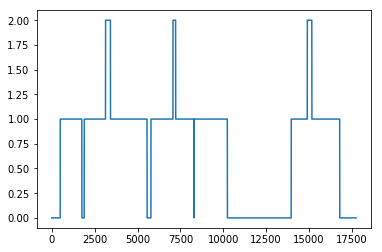

In [78]:
cov = get_cov(ref_monomers, long_edges)
plt.plot(cov)

In [79]:
long_reads = {k: v for k, v in monomer_strings.items() if len(v) >= 1000}
len(long_reads)

108

01f80610-395e-4ef8-93d0-526989b8cb53 {'editDistance': 8, 'alphabetLength': 19, 'locations': [(3836, 5046)], 'cigar': None} [[1210]]
05a4fa6a-38b1-40d6-916e-886ad1fb050b {'editDistance': 1, 'alphabetLength': 18, 'locations': [(7955, 8987)], 'cigar': None} [[1032]]
08a68948-5d96-4ed2-9632-c86d0200d914 {'editDistance': 0, 'alphabetLength': 18, 'locations': [(9967, 11037)], 'cigar': None} [[1070]]
0c50866b-f780-4551-a4bb-aa35a72f3f4d {'editDistance': 5, 'alphabetLength': 19, 'locations': [(1428, 2775)], 'cigar': None} [[1347]]
0c849de1-fbde-4ff4-bf9e-a7675a011e11 {'editDistance': 0, 'alphabetLength': 18, 'locations': [(8408, 9437)], 'cigar': None} [[1029]]
11416399-75e7-4251-824f-c17721a01605 {'editDistance': 1, 'alphabetLength': 18, 'locations': [(1745, 3131)], 'cigar': None} [[1386]]
13b093b1-6dd5-4fbe-9a41-0c927ef131ff {'editDistance': 1, 'alphabetLength': 18, 'locations': [(8957, 10358)], 'cigar': None} [[1401]]
14eb3993-37ae-468e-9e48-c2eeeb996ed3 {'editDistance': 1, 'alphabetLength':

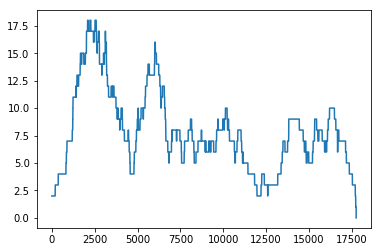

In [80]:
cov = get_cov(ref_monomers, long_reads)
plt.plot(cov)

In [81]:
def connect_edges(edges, reads, min_overlap=300, min_id=0.97):
    connections = defaultdict(list)
    for r_id, read in reads.items():
        b_pref_al, b_pref_overlap, b_pref_edge = None, 0, None
        b_suf_al, b_suf_overlap, b_suf_edge = None, 0, None
        
        # print("\n!!!!!\n")
        for e_id, edge in edges.items():
            er = identity_shift(edge, read, min_overlap, match_char=set('=?'))
            re = identity_shift(read, edge, min_overlap, match_char=set('=?'))
            if er['shift'] != None and len(er['alt_shifts']) == 0 and er['id'] > min_id \
                    and er['len'] > b_pref_overlap:
                b_pref_al = er
                b_pref_overlap = b_pref_overlap
                b_pref_edge = e_id
            
            if re['shift'] != None and len(re['alt_shifts']) == 0 and re['id'] > min_id \
                    and re['len'] > b_suf_overlap:
                b_suf_al = re
                b_suf_overlap = b_suf_overlap
                b_suf_edge = e_id
        
        if b_suf_edge is not None and b_pref_edge is not None:
            print(r_id)
            print(b_pref_edge, b_pref_al)
            print(b_suf_edge, b_suf_al)
            dist = len(read) - b_pref_al['len'] - b_suf_al['len']
            print(dist)
            connections[(b_pref_edge, b_suf_edge)].append(
                (r_id, b_pref_al['len'], b_pref_al['id'], dist, b_suf_al['len'], b_suf_al['id'])
            )
    return connections

In [82]:
connections = connect_edges(long_edges, monomer_strings)

00739941-c14c-40bd-9fad-fabff753795b
(5120, 5451, 0) {'id': 1.0, 'shift': 1227, 'hd': 0, 'len': 303, 'alt_shifts': []}
(7, 9915, 0) {'id': 1.0, 'shift': 7, 'hd': 0, 'len': 791, 'alt_shifts': []}
-296
054f1983-9204-4889-936a-64ab45e7810c
(2929, 2239, 0) {'id': 1.0, 'shift': 1341, 'hd': 0, 'len': 590, 'alt_shifts': []}
(11189, 7050, 0) {'id': 0.9970238095238095, 'shift': 365, 'hd': 1, 'len': 336, 'alt_shifts': []}
-225
057047e6-eb15-4d39-b4f6-473ecba0558a
(5120, 5451, 0) {'id': 1.0, 'shift': 1229, 'hd': 0, 'len': 301, 'alt_shifts': []}
(2466, 5451, 0) {'id': 1.0, 'shift': 115, 'hd': 0, 'len': 510, 'alt_shifts': []}
-186
05a4fa6a-38b1-40d6-916e-886ad1fb050b
(5120, 11585, 0) {'id': 1.0, 'shift': 889, 'hd': 0, 'len': 350, 'alt_shifts': []}
(2929, 2239, 0) {'id': 1.0, 'shift': 351, 'hd': 0, 'len': 681, 'alt_shifts': []}
1
0aca72fc-0a1e-416a-beb5-6b4bde55eb81
(11189, 7050, 0) {'id': 1.0, 'shift': 1246, 'hd': 0, 'len': 335, 'alt_shifts': []}
(5120, 11585, 0) {'id': 1.0, 'shift': 125, 'hd': 0, 

80e43596-26bd-4086-bb44-20f57549d706
(5120, 5451, 0) {'id': 1.0, 'shift': 1197, 'hd': 0, 'len': 333, 'alt_shifts': []}
(2466, 5451, 0) {'id': 1.0, 'shift': 255, 'hd': 0, 'len': 496, 'alt_shifts': []}
-78
814fadd3-b302-42f2-b650-d53315b7844e
(5120, 11585, 0) {'id': 1.0, 'shift': 665, 'hd': 0, 'len': 574, 'alt_shifts': []}
(2929, 2239, 0) {'id': 1.0, 'shift': 575, 'hd': 0, 'len': 341, 'alt_shifts': []}
1
81509345-296d-4e7d-9f59-b81d0cf7cb51
(5509, 11189, 0) {'id': 1.0, 'shift': 1126, 'hd': 0, 'len': 764, 'alt_shifts': []}
(11189, 7050, 0) {'id': 1.0, 'shift': 365, 'hd': 0, 'len': 1137, 'alt_shifts': []}
-399
83a800ae-fe30-456c-b2d4-63aea374b2f1
(942, 7050, 0) {'id': 1.0, 'shift': 553, 'hd': 0, 'len': 889, 'alt_shifts': []}
(5120, 11585, 0) {'id': 1.0, 'shift': 679, 'hd': 0, 'len': 500, 'alt_shifts': []}
-210
86fdd7a8-71b5-46fa-90d2-5e6888ae2289
(942, 7050, 0) {'id': 1.0, 'shift': 1011, 'hd': 0, 'len': 431, 'alt_shifts': []}
(5120, 11585, 0) {'id': 1.0, 'shift': 221, 'hd': 0, 'len': 1086,

ee68ff9e-5a90-48bd-b8bf-b4a3e2e546a1
(5120, 5451, 0) {'id': 1.0, 'shift': 330, 'hd': 0, 'len': 1200, 'alt_shifts': []}
(4445, 10624, 0) {'id': 1.0, 'shift': 912, 'hd': 0, 'len': 609, 'alt_shifts': []}
-288
f2d60e05-392e-4895-97ec-59d75e53148f
(5120, 5451, 0) {'id': 1.0, 'shift': 1068, 'hd': 0, 'len': 462, 'alt_shifts': []}
(4445, 10624, 0) {'id': 1.0, 'shift': 174, 'hd': 0, 'len': 598, 'alt_shifts': []}
-288
f3a7eb72-23c5-4c60-97d8-be9c7cb6285b
(5120, 5451, 0) {'id': 1.0, 'shift': 573, 'hd': 0, 'len': 957, 'alt_shifts': []}
(11189, 7050, 0) {'id': 0.9973474801061007, 'shift': 699, 'hd': 1, 'len': 377, 'alt_shifts': []}
-258
f58c38d8-7d74-46a1-8be2-cd259ff596da
(5120, 5451, 0) {'id': 1.0, 'shift': 1141, 'hd': 0, 'len': 389, 'alt_shifts': []}
(4445, 10624, 0) {'id': 1.0, 'shift': 101, 'hd': 0, 'len': 510, 'alt_shifts': []}
-288
f79edf05-1c15-4303-9584-b421c5ada908
(5120, 5451, 0) {'id': 1.0, 'shift': 1154, 'hd': 0, 'len': 376, 'alt_shifts': []}
(4445, 10624, 0) {'id': 1.0, 'shift': 88, '

(7, 9915, 0) {'editDistance': 2, 'alphabetLength': 18, 'locations': [(489, 1750)], 'cigar': None} [[1261]]
(942, 7050, 0) {'editDistance': 27, 'alphabetLength': 18, 'locations': [(5781, 7221)], 'cigar': None} [[1440]]
(2466, 5451, 0) {'editDistance': 1, 'alphabetLength': 18, 'locations': [(13962, 15165)], 'cigar': None} [[1203]]
(2929, 2239, 0) {'editDistance': 0, 'alphabetLength': 18, 'locations': [(8307, 10237)], 'cigar': None} [[1930]]
(4445, 10624, 0) {'editDistance': 6, 'alphabetLength': 18, 'locations': [(3132, 5554)], 'cigar': None} [[2422]]
(5120, 5451, 0) {'editDistance': 1, 'alphabetLength': 18, 'locations': [(1889, 3419)], 'cigar': None} [[1530]]
(5120, 11585, 0) {'editDistance': 0, 'alphabetLength': 18, 'locations': [(7066, 8304)], 'cigar': None} [[1238]]
(5509, 11189, 0) {'editDistance': 3, 'alphabetLength': 18, 'locations': [(14899, 16790)], 'cigar': None} [[1891]]
(11189, 7050, 0) {'editDistance': 63, 'alphabetLength': 18, 'locations': [(1469, 3089), (1469, 3090), (1469,

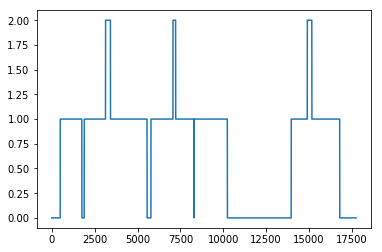

In [83]:
cov = get_cov(ref_monomers, long_edges)
plt.plot(cov)

In [84]:
connections

defaultdict(list,
            {((7, 9915, 0),
              (7, 9915, 0)): [('6e54ff5e-7a55-4dad-bae3-004d255dddbd',
               310,
               0.9741935483870968,
               -194,
               1203,
               0.99833748960931), ('7e9301cd-6184-44f7-9db4-849ac08d33a5',
               308,
               0.9805194805194806,
               -50,
               380,
               1.0), ('8e85dd90-8045-4df1-ba7b-b6b576deaa4d',
               308,
               0.9805194805194806,
               -284,
               771,
               1.0), ('9e50bfee-7cce-4e72-9557-e40959c5fc51',
               535,
               1.0,
               -140,
               302,
               1.0), ('a7a6eb6b-2225-4396-bb6b-2c0809993922',
               309,
               0.9773462783171522,
               -86,
               617,
               1.0), ('db403540-296f-4a52-b04b-489c9f8116ef',
               309,
               0.9773462783171522,
               148,
               354,
 

In [85]:
for edge_pair, read_list in connections.items():
    dist_cnt = Counter(x[3] for x in read_list)
    mc = dist_cnt.most_common(1)
    if mc[0][1] >= 2:
        print(edge_pair)
        for r_id, pref_ov_len, pref_ov_id, dist, suf_ov_len, suf_ov_id in read_list:
            print(f'{r_id} {pref_ov_len:4} {pref_ov_id:5.2}, {dist:4}, {suf_ov_len:4}, {suf_ov_id:5.2}')
        print("")

((5120, 11585, 0), (2929, 2239, 0))
05a4fa6a-38b1-40d6-916e-886ad1fb050b  350   1.0,    1,  681,   1.0
2150aca2-413b-4207-ab2d-ac2f390a625d  586   1.0,    1,  641,   1.0
814fadd3-b302-42f2-b650-d53315b7844e  574   1.0,    1,  341,   1.0
a61180df-982c-4d59-b8b3-eedad055ac2e  454   1.0,    1,  537,   1.0
e7f9d7d2-9144-4693-b36e-e5c7e1fce608  565   1.0,    1, 1745,   1.0

((11189, 7050, 0), (5120, 11585, 0))
0aca72fc-0a1e-416a-beb5-6b4bde55eb81  335   1.0, -210,  653,   1.0
7c28cc24-1d36-456f-a02c-bef0849fbf2a  391   1.0, -210,  529,   1.0

((2466, 5451, 0), (5509, 11189, 0))
0b1f944b-90f7-4e17-a1cd-f02d38d0f84c  475   1.0, -267,  441,   1.0
a5bfccd4-6695-42aa-aba2-6d4b2ca248b4  594   1.0, -267,  464,   1.0

((7, 9915, 0), (5120, 5451, 0))
0c50866b-f780-4551-a4bb-aa35a72f3f4d  323   1.0,  136,  887,   1.0
1b4bd09e-07f3-4455-b041-c4599b6fbe3d  901   1.0,  138, 1418,   1.0
2fef785e-910e-4071-87f5-ba59052d4f7f  560   1.0,  138,  712,   1.0
35aded7d-a60e-4628-ab38-4fd91010c0f6  524   1.0,  13

In [86]:
def map_reads(monomer_strings, db, db_index=None):
    if db_index is None:
        db_index = db.index_edges()
    mapping = {}
    db_edges = list(db.graph.edges(keys=True))
    for r_id, string in monomer_strings.items():
        split_strings = list(filter(lambda string: len(string), string.split('=')))
        split_lens = [0] + [len(split_string) for split_string in split_strings]
        cum_split_lens = np.cumsum(split_lens)
        read_coords = []
        for split_ind, split_string in enumerate(split_strings):
            for i in range(len(split_string)-db.k+1):
                kmer = split_string[i:i+db.k]
                if kmer in db_index[len(kmer)]:
                    read_coords.append(db_index[len(kmer)][kmer])
        
        path = [x[0] for x in read_coords]
        path = [x[0] for x in groupby(path)]
        path = [db_edges[edge_ind] for edge_ind in path]
        
        valid_path = True
        for e1, e2 in zip(path[:-1], path[1:]):
            if e1[1] != e2[0]:
                valid_path = False
                break
        if len(read_coords):
            mapping[r_id] = (read_coords[0], read_coords[-1], valid_path, path)
        else:
            mapping[r_id] = None
    return mapping

mappings = map_reads(monomer_strings, db)

print(np.mean([read_mapping is not None for read_mapping in mappings.values()]))
print(np.mean([read_mapping[2] for read_mapping in mappings.values() \
               if read_mapping is not None]))
print(np.sum([read_mapping[2] for read_mapping in mappings.values() \
               if read_mapping is not None]))

for r_id, read_mapping in mappings.items():
    if read_mapping is not None and read_mapping[2]:
        print(r_id, len(monomer_strings[r_id]), len(monomer_strings[r_id]) * 171,
              len(db.get_path(read_mapping[-1])), read_mapping)

0.943488943489
0.981770833333
377
00739941-c14c-40bd-9fad-fabff753795b 798 136458 1357 ((22, 90), (0, 391), True, [(5087, 7, 0), (7, 9915, 0)])
01f80610-395e-4ef8-93d0-526989b8cb53 1214 207594 2426 ((13, 704), (13, 1513), True, [(4445, 10624, 0)])
0352811e-b17c-4fc1-a73f-99757d30745c 623 106533 1665 ((49, 93), (1, 93), True, [(13393, 942, 0), (942, 7050, 0)])
04203cad-4a32-4b9c-b7dd-c8603e54b46b 620 106020 1890 ((34, 373), (34, 429), True, [(5509, 11189, 0)])
04b2f961-f6b4-438d-9a64-83dbd6049ffc 799 136629 1581 ((44, 565), (44, 964), True, [(11189, 7050, 0)])
050b88c4-e343-431d-99dc-4b8151b4adef 707 120897 1890 ((34, 616), (34, 923), True, [(5509, 11189, 0)])
0540aa3e-f34b-4e74-a5e5-884b69594a0d 641 109611 1581 ((44, 209), (44, 450), True, [(11189, 7050, 0)])
054f1983-9204-4889-936a-64ab45e7810c 701 119871 2051 ((10, 1341), (5, 32), True, [(2929, 2239, 0), (2239, 2275, 0), (2275, 2317, 0), (2317, 5625, 0)])
057047e6-eb15-4d39-b4f6-473ecba0558a 625 106875 1341 ((12, 23), (9, 110), True,

e848aea3-e268-4fec-89cf-f1f230acbd0b 738 126198 1931 ((10, 117), (10, 304), True, [(2929, 2239, 0)])
e98f9879-3e90-4503-a35e-54d944e03f98 1756 300276 3297 ((3, 38), (10, 28), True, [(2275, 2317, 0), (2317, 5045, 0), (5045, 5054, 0), (5054, 5078, 0), (5078, 5087, 0), (5087, 5090, 0), (5090, 5105, 0), (5105, 5120, 0), (5120, 11585, 0), (11585, 2929, 0), (2929, 2239, 0)])
e9f2bcf1-90bc-4a82-957b-73d055b42582 937 160227 1044 ((7, 4), (16, 204), True, [(2415, 4554, 0), (4554, 4728, 0), (4728, 3889, 1)])
ea6a949b-b0c9-4694-9fb5-cae9e9f915de 1348 230508 2450 ((35, 8), (13, 943), True, [(5625, 4445, 0), (4445, 10624, 0)])
ea8138e6-df5a-4f84-aff5-5d1cb8ca5ed1 1541 263511 2471 ((1, 221), (28, 130), True, [(942, 7050, 0), (7050, 2275, 0), (2275, 2317, 0), (2317, 5045, 0), (5045, 5054, 0), (5054, 5078, 0), (5078, 5087, 0), (5087, 5090, 0), (5090, 5105, 0), (5105, 5120, 0), (5120, 11585, 0)])
ea82504c-7b3e-4249-a1bc-c1ef516358c8 1221 208791 2010 ((15, 283), (9, 297), True, [(4728, 3889, 0), (3889, 

## Connection between A  = (7, 9915, 0) and B = (5120, 5451, 0)

In [98]:
# monomers2units(long_edges[(7, 9915, 0)]) # A in unit form
# monomers2units(long_edges[(5120, 5451, 0)]) # B in unit form

In [99]:
# monomers2units(db.graph.get_edge_data(9915, 7, 0)['edge_kmer'])

In [100]:
# monomers2units(db.graph.get_edge_data(14132, 5491, 0)['edge_kmer'])

In [101]:
# monomers2units(monomer_strings['ab79a298-1f1a-44da-a174-6a52ae8abfcd'])

In [102]:
# monomer_strings['0c50866b-f780-4551-a4bb-aa35a72f3f4d'][323:323+136]

In [103]:
# monomer_strings['1b4bd09e-07f3-4455-b041-c4599b6fbe3d'][901:901+138]

In [104]:
# get_paths_thru_complex_nodes(dbs[303], monomer_strings)

In [106]:
# monomers2units(dbs[303].graph.get_edge_data(7, 8, 0)['edge_kmer'])

In [105]:
# monomers2units(dbs[303].graph.get_edge_data(8, 7, 0)['edge_kmer'])

In [108]:
# mappings = map_reads({'ab79a298-1f1a-44da-a174-6a52ae8abfcd': monomer_strings['ab79a298-1f1a-44da-a174-6a52ae8abfcd']},
#                     dbs[304])

In [109]:
# mappings

In [110]:
# dbs[303].rev_node_mapping[8]

In [111]:
# dbs[303].rev_node_mapping[3199]

In [112]:
# dbs[303].rev_node_mapping[7]

In [113]:
# dbs[304].rev_node_mapping[7]

In [114]:
# erroneous_kmer = dbs[304].graph.get_edge_data(6732, 7, 0)['edge_kmer']
# len(erroneous_kmer)

In [115]:
# cnt_erroneous_kmer = 0
# for _ in monomer_strings.values():
#     __ = Counter([_[i:i+len(erroneous_kmer)] for i in range(len(_)-len(erroneous_kmer)+1)])
#     cnt_erroneous_kmer += __[erroneous_kmer]
# print(cnt_erroneous_kmer)

In [116]:
# dbs[304].graph.get_edge_data(7, 13999, 0)['edge_kmer'][:303]

In [117]:
# erroneous_kmer

In [118]:
# dbs[303].graph.get_edge_data(8, 13964, 0)['edge_kmer'][:302]

In [119]:
# dbs[303].graph.get_edge_data(7, 8, 0)['edge_kmer']

In [120]:
# all_frequent_kmers_read_pos[304][dbs[304].graph.get_edge_data(6732, 7, 0)['edge_kmer']]

In [121]:
# for contig_path in dbs[303].get_contigs()[1]:
#     if dbs[303].get_path(contig_path) == dbs[303].get_contigs()[0][21]:
#        print(contig_path)
#         print(dbs[303].get_path(contig_path))
#         print(erroneous_kmer in dbs[303].get_path(contig_path))

In [122]:
# print(dbs[303].rev_node_mapping[7])

## Connection between B = (5120, 5451, 0) and C  = (4445, 10624, 0) 

In [87]:
mappings = map_reads({'aff6bdf9-4388-46e6-9aa5-af5c6c88258d': monomer_strings['aff6bdf9-4388-46e6-9aa5-af5c6c88258d']},
                     dbs[400])



In [88]:
mappings

{'aff6bdf9-4388-46e6-9aa5-af5c6c88258d': ((27, 1029),
  (13, 1021),
  True,
  [(5120, 5451, 0),
   (5451, 5045, 0),
   (5045, 5054, 0),
   (5054, 5500, 0),
   (5500, 5509, 0),
   (5509, 5625, 0),
   (5625, 4445, 0),
   (4445, 10624, 0)])}

In [123]:
def code_hor(units):
    code_units = []
    i = 0
    while i < len(units) - 1:
        u1, u2 = units[i], units[i+1]
        if u1 == ((0, 1), 1) and u2 == ((5, 17), 1):
            code_units.append('M')
            i += 2
        else:
            code_units.append(u1)
            i += 1
    compressed_units = []
    for key, group in groupby(code_units):
        if len(list(group)) == 1:
            compressed_units.append(key)
        else:
            compressed_units.append((key[0], len(list(group))))
    return compressed_units

In [125]:
monomers2units(long_edges[(4445, 10624, 0)]) # C in unit form

[((11, 17), 1),
 ('Full', 18),
 ((0, 1), 1),
 ((5, 17), 1),
 ('Full', 1),
 ((0, 1), 1),
 ((5, 17), 1),
 ('Full', 1),
 ((0, 1), 1),
 ((5, 17), 1),
 ('Full', 1),
 ((0, 1), 1),
 ((5, 17), 1),
 ('Full', 1),
 ((0, 1), 1),
 ((5, 17), 1),
 ((0, 1), 1),
 ((5, 17), 1),
 ((0, 1), 1),
 ((5, 17), 1),
 ('Full', 3),
 ((0, 1), 1),
 ((5, 17), 1),
 ('Full', 1),
 ((0, 1), 1),
 ((5, 17), 1),
 ((0, 1), 1),
 ((5, 17), 1),
 ((0, 0), 1),
 ((3, 17), 1),
 ((0, 1), 1),
 ((5, 17), 1),
 ('Full', 3),
 ((0, 1), 1),
 ((5, 17), 1),
 ((0, 1), 1),
 ((5, 17), 1),
 ((0, 1), 1),
 ((5, 17), 1),
 ('Full', 2),
 ((0, 1), 1),
 ((5, 17), 1),
 ('Full', 3),
 ((0, 1), 1),
 ((5, 17), 1),
 ('Full', 3),
 ((0, 1), 1),
 ((5, 17), 1),
 ('Full', 1),
 ((0, 1), 1),
 ((5, 17), 1),
 ('Full', 2),
 ((0, 6), 1),
 ((0, 1), 1),
 ((5, 17), 1),
 ((0, 1), 1),
 ((5, 17), 1),
 ('Full', 5),
 ((0, 1), 1),
 ((5, 17), 1),
 ('Full', 12),
 ((0, 1), 1),
 ((5, 17), 1),
 ('Full', 2),
 ((0, 1), 1),
 ((5, 17), 1),
 ('Full', 12),
 ((0, 2), 1),
 ((6, 17), 1),
 ((0

In [132]:
mappings = map_reads({'f3a7eb72-23c5-4c60-97d8-be9c7cb6285b': monomer_strings['f3a7eb72-23c5-4c60-97d8-be9c7cb6285b']},
                     dbs[400])



In [133]:
mappings

{'f3a7eb72-23c5-4c60-97d8-be9c7cb6285b': ((27, 573),
  (13, 7),
  True,
  [(5120, 5451, 0),
   (5451, 5045, 0),
   (5045, 5054, 0),
   (5054, 5500, 0),
   (5500, 5509, 0),
   (5509, 5625, 0),
   (5625, 4445, 0),
   (4445, 10624, 0)])}

## Connection between C  = (4445, 10624, 0) and D = (942, 7050, 0)

In [288]:
mappings = map_reads(monomer_strings,
                     dbs[400])



In [134]:
monomers2units(long_edges[(942, 7050, 0)]) # D in unit form

[((6, 17), 1),
 ('Full', 3),
 ((0, 1), 1),
 ((5, 17), 1),
 ((0, 1), 1),
 ((5, 17), 1),
 ('Full', 1),
 ((0, 1), 1),
 ((5, 17), 1),
 ((0, 1), 1),
 ((5, 17), 1),
 ('Full', 3),
 ((0, 1), 1),
 ((5, 17), 1),
 ((0, 1), 1),
 ((5, 17), 1),
 ('Full', 2),
 ((0, 1), 1),
 ((5, 17), 1),
 ((0, 1), 1),
 ((5, 17), 1),
 ('Full', 1),
 ((0, 1), 1),
 ((5, 17), 1),
 ('Full', 2),
 ((0, 1), 1),
 ((5, 17), 1),
 ('Full', 2),
 ((0, 1), 1),
 ((5, 17), 1),
 ('Full', 2),
 ((0, 1), 1),
 ((5, 17), 1),
 ('Full', 2),
 ((0, 1), 1),
 ((5, 17), 1),
 ((0, 1), 1),
 ((5, 17), 1),
 ((0, 1), 1),
 ((5, 17), 1),
 ((0, 1), 1),
 ((5, 17), 1),
 ('Full', 4),
 ((0, 1), 1),
 ((5, 17), 1),
 ((0, 1), 1),
 ((5, 17), 1),
 ((0, 1), 1),
 ((5, 17), 1),
 ('Full', 2),
 ((0, 1), 1),
 ((5, 17), 1),
 ((0, 1), 1),
 ((5, 17), 1),
 ('Full', 1),
 ((0, 1), 1),
 ((5, 17), 1),
 ('Full', 1),
 ((0, 1), 1),
 ((5, 17), 1),
 ('Full', 2),
 ((0, 1), 1),
 ((5, 17), 1),
 ('Full', 1),
 ((0, 1), 1),
 ((5, 17), 1),
 ((0, 1), 1),
 ((5, 17), 1),
 ('Full', 1),
 ((0, 1

In [136]:
mappings['2d7e41d5-9657-4c4a-bafe-de2baf162d51']

((40, 47),
 (1, 53),
 True,
 [(10624, 12416, 0), (12416, 11008, 0), (11008, 942, 0), (942, 7050, 0)])

In [137]:
mappings['347cb721-6ad0-4df3-9bd2-4bc0a3c08c8d']

((13, 1911),
 (1, 468),
 True,
 [(4445, 10624, 0),
  (10624, 12416, 0),
  (12416, 13393, 0),
  (13393, 942, 0),
  (942, 7050, 0)])

In [138]:
mappings['459cabbd-30ad-4a2a-985a-5983b49e50ff']

((13, 1677),
 (1, 162),
 True,
 [(4445, 10624, 0),
  (10624, 12416, 0),
  (12416, 11008, 0),
  (11008, 942, 0),
  (942, 7050, 0)])

In [139]:
mappings['535aa52e-6acc-4f47-af7f-e728e2b8c0bc']

((13, 1660),
 (1, 376),
 True,
 [(4445, 10624, 0),
  (10624, 12416, 0),
  (12416, 11008, 0),
  (11008, 942, 0),
  (942, 7050, 0)])

In [146]:
dbs[400].rev_node_mapping[13393]

'FGHIJKLMNOPQRABFGHIJKLMNOPQRABFGHIJKLMNOPQRABFGHIJKLMNOPQRABCDEFGHIJKLMNOPQRABFGHIJKLMNOPQRABFGHIJKLMNOPQRABCDEFGHIJKLMNOPQRABFGHIJKLMNOPQRABCDEFGHIJKLMNOPQRABCDEFGHIJKLMNOPQRABFGHIJKLMNOPQRABFGHIJKLMNOPQRABFGHIJKLMNOPQRABCGHIJKLMNOPQRABCDEFGHIJKLMNOPQRABCDEFGHIJKLMNOPQRABCDEFGHIJKLMNOPQRABFGHIJKLMNOPQRABFGHIJKLMNOPQRABCDEFGHIJKLMNOPQRABFGHIJKLMNOPQRABFGHIJKLMNOPQRABCDEFGHIJKLMNOPQRABCDEFGHIJKLMN'

In [144]:
dbs[400].rev_node_mapping[11008]

'FGHIJKLMNOPQRABFGHIJKLMNOPQRABFGHIJKLMNOPQRABFGHIJKLMNOPQRABCDEFGHIJKLMNOPQRABFGHIJKLMNOPQRABFGHIJKLMNOPQRABCDEFGHIJKLMNOPQRABFGHIJKLMNOPQRABCDEFGHIJKLMNOPQRABCDEFGHIJKLMNOPQRABFGHIJKLMNOPQRABFGHIJKLMNOPQRABFGHIJKLMNOPQRABFGHIJKLMNOPQRABCDEFGHIJKLMNOPQRABCDEFGHIJKLMNOPQRABCDEFGHIJKLMNOPQRABFGHIJKLMNOPQRABFGHIJKLMNOPQRABCDEFGHIJKLMNOPQRABFGHIJKLMNOPQRABFGHIJKLMNOPQRABCDEFGHIJKLMNOPQRABCDEFGHIJKLMN'

In [149]:
for i, (c1, c2) in enumerate(zip(dbs[400].rev_node_mapping[13393], dbs[400].rev_node_mapping[11008])):
    if c1 == c2 :
        print(i, c1.lower(), c2.lower())
    else:
        print(i, c1, c2, '!')

0 f f
1 g g
2 h h
3 i i
4 j j
5 k k
6 l l
7 m m
8 n n
9 o o
10 p p
11 q q
12 r r
13 a a
14 b b
15 f f
16 g g
17 h h
18 i i
19 j j
20 k k
21 l l
22 m m
23 n n
24 o o
25 p p
26 q q
27 r r
28 a a
29 b b
30 f f
31 g g
32 h h
33 i i
34 j j
35 k k
36 l l
37 m m
38 n n
39 o o
40 p p
41 q q
42 r r
43 a a
44 b b
45 f f
46 g g
47 h h
48 i i
49 j j
50 k k
51 l l
52 m m
53 n n
54 o o
55 p p
56 q q
57 r r
58 a a
59 b b
60 c c
61 d d
62 e e
63 f f
64 g g
65 h h
66 i i
67 j j
68 k k
69 l l
70 m m
71 n n
72 o o
73 p p
74 q q
75 r r
76 a a
77 b b
78 f f
79 g g
80 h h
81 i i
82 j j
83 k k
84 l l
85 m m
86 n n
87 o o
88 p p
89 q q
90 r r
91 a a
92 b b
93 f f
94 g g
95 h h
96 i i
97 j j
98 k k
99 l l
100 m m
101 n n
102 o o
103 p p
104 q q
105 r r
106 a a
107 b b
108 c c
109 d d
110 e e
111 f f
112 g g
113 h h
114 i i
115 j j
116 k k
117 l l
118 m m
119 n n
120 o o
121 p p
122 q q
123 r r
124 a a
125 b b
126 f f
127 g g
128 h h
129 i i
130 j j
131 k k
132 l l
133 m m
134 n n
135 o o
136 p p
137 q q
138 r 

In [153]:
all_frequent_kmers_read_pos[399][dbs[400].rev_node_mapping[11008]]

[('1df6a0f7-28ca-432e-b09c-15f7d61639e0', 606),
 ('2d7e41d5-9657-4c4a-bafe-de2baf162d51', 355),
 ('2e877b89-1026-41a9-9222-479ec6917173', 434),
 ('459cabbd-30ad-4a2a-985a-5983b49e50ff', 752),
 ('535aa52e-6acc-4f47-af7f-e728e2b8c0bc', 769),
 ('89babdc7-ef9b-43ac-bcfc-0265733886ed', 366),
 ('9bf34c41-751f-4ef2-b150-b4e287b12eaa', 394),
 ('9c6be407-612e-4e37-becb-34e62c64c7e2', 556),
 ('c774cf4a-14a9-4432-9992-53fa6813189f', 308),
 ('d2f81138-e67b-4063-bdeb-3a4f5f9c31e0', 642),
 ('de3d213f-2367-4dc5-b4ee-14195aa97884', 7),
 ('fd7ab94c-96fc-4448-bb9d-2c7a86d777b9', 197),
 ('contig_k398_i24_j0', 175),
 ('contig_k398_i24_j1', 175),
 ('contig_k398_i24_j2', 175),
 ('contig_k398_i24_j3', 175),
 ('contig_k398_i24_j4', 175),
 ('contig_k398_i27_j0', 175),
 ('contig_k398_i27_j1', 175),
 ('contig_k398_i27_j2', 175),
 ('contig_k398_i27_j3', 175),
 ('contig_k398_i27_j4', 175)]

In [152]:
all_frequent_kmers_read_pos[399][dbs[400].rev_node_mapping[13393]]

[('347cb721-6ad0-4df3-9bd2-4bc0a3c08c8d', 518),
 ('46a4165e-6315-4339-9d4e-3af1ca00b3fc', 94),
 ('b55aea96-cbe9-4c7b-9b0a-0501dd830ba8', 396),
 ('f9774a7d-75d0-4783-8053-ce259920fc2e', 120),
 ('contig_k398_i7_j0', 175),
 ('contig_k398_i7_j1', 175),
 ('contig_k398_i7_j2', 175),
 ('contig_k398_i7_j3', 175),
 ('contig_k398_i7_j4', 175),
 ('contig_k398_i36_j0', 175),
 ('contig_k398_i36_j1', 175),
 ('contig_k398_i36_j2', 175),
 ('contig_k398_i36_j3', 175),
 ('contig_k398_i36_j4', 175)]

In [154]:
mappings['9bf34c41-751f-4ef2-b150-b4e287b12eaa']

((13, 2017),
 (43, 165),
 True,
 [(4445, 10624, 0), (10624, 10831, 0), (10831, 11008, 0), (11008, 942, 0)])

In [155]:
mappings['9c6be407-612e-4e37-becb-34e62c64c7e2']

((13, 1855),
 (43, 142),
 True,
 [(4445, 10624, 0), (10624, 10831, 0), (10831, 11008, 0), (11008, 942, 0)])

In [156]:
mappings['b55aea96-cbe9-4c7b-9b0a-0501dd830ba8']

((13, 2015),
 (1, 118),
 True,
 [(4445, 10624, 0),
  (10624, 10831, 0),
  (10831, 13393, 0),
  (13393, 942, 0),
  (942, 7050, 0)])

In [157]:
mappings['d2f81138-e67b-4063-bdeb-3a4f5f9c31e0']

((13, 1769),
 (1, 183),
 True,
 [(4445, 10624, 0),
  (10624, 10831, 0),
  (10831, 11008, 0),
  (11008, 942, 0),
  (942, 7050, 0)])

## Connection between D = (942, 7050, 0) and E  = (5120, 11585, 0) 

In [158]:
mappings['86fdd7a8-71b5-46fa-90d2-5e6888ae2289']

((1, 1011),
 (28, 686),
 True,
 [(942, 7050, 0),
  (7050, 2275, 0),
  (2275, 2317, 0),
  (2317, 5045, 0),
  (5045, 5054, 0),
  (5054, 5078, 0),
  (5078, 5087, 0),
  (5087, 5090, 0),
  (5090, 5105, 0),
  (5105, 5120, 0),
  (5120, 11585, 0)])

In [176]:
def get_edge_cov(mappings, db):
    cov = {}
    for edge in db.graph.edges(keys=True):
         cov[edge] = 0
    
    for r_id, mapping in mappings.items():
        if mapping is not None and mapping[-2]:
            for edge in mapping[-1]:
                cov[edge] += 1
    return cov

In [177]:
edge_cov = get_edge_cov(mappings=mappings, db=dbs[400])

In [178]:
for e_id, e_cov in edge_cov.items():
    if e_cov == 0:
        print(e_id, e_cov)

(9915, 7, 0) 0
(15296, 15675, 0) 0
(15330, 11189, 0) 0


In [188]:
edge_cov[(4554, 4728,0)]

29

In [194]:
for r_id, mapping in mappings.items():
    if mapping is not None and mapping[-2]:
        if (4445, 10624, 0) in mapping[-1]:
            print(r_id, mapping[-1])

01f80610-395e-4ef8-93d0-526989b8cb53 [(4445, 10624, 0)]
079aa8c8-90a4-4fe8-af37-d9170f7d82b7 [(4445, 10624, 0)]
0edd79ac-1cdd-4677-8898-71aae0d5c1c3 [(4445, 10624, 0)]
14eb3993-37ae-468e-9e48-c2eeeb996ed3 [(4445, 10624, 0)]
1df6a0f7-28ca-432e-b09c-15f7d61639e0 [(4445, 10624, 0), (10624, 10831, 0), (10831, 11008, 0), (11008, 942, 0)]
24ae0ff5-199f-441f-8f6e-c127eedf888e [(4445, 10624, 0), (10624, 12416, 0)]
2b30c216-e7bb-465a-bc1b-1847312ecdc4 [(4445, 10624, 0)]
2e877b89-1026-41a9-9222-479ec6917173 [(4445, 10624, 0), (10624, 10831, 0), (10831, 11008, 0), (11008, 942, 0)]
32aca0e3-fbd9-4730-abc9-19fd94edf078 [(5120, 5451, 0), (5451, 5045, 0), (5045, 5054, 0), (5054, 5500, 0), (5500, 5509, 0), (5509, 5625, 0), (5625, 4445, 0), (4445, 10624, 0)]
347cb721-6ad0-4df3-9bd2-4bc0a3c08c8d [(4445, 10624, 0), (10624, 12416, 0), (12416, 13393, 0), (13393, 942, 0), (942, 7050, 0)]
37935cc3-3b9e-4f66-bea9-eec5aef4f7fd [(4445, 10624, 0), (10624, 10831, 0)]
385826e5-a023-4543-966c-b69c8f2501a5 [(4445, 1

In [195]:
monomers2units(long_edges[(5120, 11585, 0)]) # D in unit form

[((11, 17), 1),
 ('Full', 20),
 ((0, 1), 1),
 ((5, 17), 1),
 ((0, 1), 1),
 ((5, 17), 1),
 ((0, 1), 1),
 ((5, 17), 1),
 ((0, 1), 1),
 ((5, 17), 1),
 ((0, 1), 1),
 ((5, 17), 1),
 ((0, 1), 1),
 ((5, 17), 1),
 ((0, 1), 1),
 ((5, 17), 1),
 ((0, 1), 1),
 ((5, 17), 1),
 ((0, 1), 1),
 ((5, 17), 1),
 ((0, 1), 1),
 ((5, 17), 1),
 ((0, 1), 1),
 ((5, 17), 1),
 ('Full', 1),
 ((0, 1), 1),
 ((5, 17), 1),
 ((0, 1), 1),
 ((5, 17), 1),
 ((0, 1), 1),
 ((5, 17), 1),
 ((0, 1), 1),
 ((5, 17), 1),
 ('Full', 2),
 ((0, 1), 1),
 ((5, 17), 1),
 ((0, 1), 1),
 ((5, 17), 1),
 ((0, 1), 1),
 ((5, 17), 1),
 ('Full', 1),
 ((0, 1), 1),
 ((5, 17), 1),
 ((0, 1), 1),
 ((5, 17), 1),
 ('Full', 1),
 ((0, 1), 1),
 ((5, 17), 1),
 ((0, 1), 1),
 ((5, 17), 1),
 ((0, 1), 1),
 ((5, 17), 1),
 ('Full', 2),
 ((0, 1), 1),
 ((5, 17), 1),
 ((0, 1), 1),
 ((5, 17), 1),
 ((0, 1), 1),
 ((5, 17), 1),
 ((0, 1), 1),
 ((5, 17), 1),
 ((0, 1), 1),
 ((5, 17), 1),
 ((0, 1), 1),
 ((5, 17), 1),
 ((0, 1), 1),
 ((5, 17), 1),
 ((0, 1), 1),
 ((5, 17), 1),


## Connection between E  = (5120, 11585, 0) and F = (2929, 1532, 0) 

In [201]:
dbs[400].graph.get_edge_data(11585, 2929, 0)['edge_kmer']

'FGHIJKLMNOPQRABFGHIJKLMNOPQRABFGHIJKLMNOPQRABFGHIJKLMNOPQRABFGHIJKLMNOPQRABFGHIJKLMNOPQRABFGHIJKLMNOPQRABFGHIJKLMNOPQRABFGHIJKLMNOPQRABFGHIJKLMNOPQRABCDEFGHIJKLMNOPQRABFGHIJKLMNOPQRABFGHIJKLMNOPQRABFGHIJKLMNOPQRABCDEFGHIJKLMNOPQRABCDEFGHIJKLMNOPQRABCDEFGHIJKLMNOPQRABCDEFGHIJKLMNOPQRABFGHIJKLMNOPQRABCDEFGHIJKLMNOPQRABFGHIJKLMNOPQRABCDEFGHIJKLMNOPQRABCDEFGHIJKLMNOPQRABFGHIJKLMNOPQRABFGHIJKLMNOPQRABCGHIJKLMNOPQRABCDEFGHIJKLMNOPQRABCDEFGHIJKLMNOPQRABCDEFGHIJKLMNOPQRABFGHIJKLMNOPQRABFGHIJKLMNOPQRABCDEFGHIJKLMNOPQRABFGHIJKLMNOPQRABCDEFGHIJKLMNOPQRABCDEFGHIJKLMNOPQRABFGHIJKLMNOPQRABCDEFGHIJKLMNOPQRABCDEFGHIJKLMNOPQRABFGHIJKLMNOPQRABFGHIJKLMNOPQRABCDEFGHIJKLMNOPQRABCDEFGHIJKLMNOPQRABFGHIJKLMNOPQRABCDEFGHIJKLMNOPQRABCDEFGHIJKLMNOPQRABCDEFGHIJKLMNOPQRABFGHIJKLMNOPQRABFGHIJKLMNOPQRABFGHIJKLMNOPQRABC'

In [202]:
dbs[400].graph.get_edge_data(11585, 2929, 1)['edge_kmer']

'FGHIJKLMNOPQRABFGHIJKLMNOPQRABFGHIJKLMNOPQRABFGHIJKLMNOPQRABFGHIJKLMNOPQRABFGHIJKLMNOPQRABFGHIJKLMNOPQRABFGHIJKLMNOPQRABFGHIJKLMNOPQRABFGHIJKLMNOPQRABCDEFGHIJKLMNOPQRABFGHIJKLMNOPQRABFGHIJKLMNOPQRABFGHIJKLMNOPQRABCDEFGHIJKLMNOPQRABCDEFGHIJKLMNOPQRABCDEFGHIJKLMNOPQRABCDEFGHIJKLMNOPQRABFGHIJKLMNOPQRABCDEFGHIJKLMNOPQRABFGHIJKLMNOPQRABCDEFGHIJKLMNOPQRABCDEFGHIJKLMNOPQRABFGHIJKLMNOPQRABFGHIJKLMNOPQRABFGHIJKLMNOPQRABCDEFGHIJKLMNOPQRABCDEFGHIJKLMNOPQRABCDEFGHIJKLMNOPQRABFGHIJKLMNOPQRABFGHIJKLMNOPQRABCDEFGHIJKLMNOPQRABFGHIJKLMNOPQRABCDEFGHIJKLMNOPQRABCDEFGHIJKLMNOPQRABFGHIJKLMNOPQRABCDEFGHIJKLMNOPQRABCDEFGHIJKLMNOPQRABFGHIJKLMNOPQRABFGHIJKLMNOPQRABCDEFGHIJKLMNOPQRABCDEFGHIJKLMNOPQRABFGHIJKLMNOPQRABCDEFGHIJKLMNOPQRABCDEFGHIJKLMNOPQRABCDEFGHIJKLMNOPQRABFGHIJKLMNOPQRABFGHIJKLMNOPQRABFGHIJKLMNOPQRABC'

In [205]:
for i, (c1, c2) in enumerate(zip(dbs[400].graph.get_edge_data(11585, 2929, 0)['edge_kmer'],
                                 dbs[400].graph.get_edge_data(11585, 2929, 1)['edge_kmer'])):
    if c1 == c2 :
        print(i, c1.lower(), c2.lower())
    else:
        print(i, c1, c2, '!')

0 f f
1 g g
2 h h
3 i i
4 j j
5 k k
6 l l
7 m m
8 n n
9 o o
10 p p
11 q q
12 r r
13 a a
14 b b
15 f f
16 g g
17 h h
18 i i
19 j j
20 k k
21 l l
22 m m
23 n n
24 o o
25 p p
26 q q
27 r r
28 a a
29 b b
30 f f
31 g g
32 h h
33 i i
34 j j
35 k k
36 l l
37 m m
38 n n
39 o o
40 p p
41 q q
42 r r
43 a a
44 b b
45 f f
46 g g
47 h h
48 i i
49 j j
50 k k
51 l l
52 m m
53 n n
54 o o
55 p p
56 q q
57 r r
58 a a
59 b b
60 f f
61 g g
62 h h
63 i i
64 j j
65 k k
66 l l
67 m m
68 n n
69 o o
70 p p
71 q q
72 r r
73 a a
74 b b
75 f f
76 g g
77 h h
78 i i
79 j j
80 k k
81 l l
82 m m
83 n n
84 o o
85 p p
86 q q
87 r r
88 a a
89 b b
90 f f
91 g g
92 h h
93 i i
94 j j
95 k k
96 l l
97 m m
98 n n
99 o o
100 p p
101 q q
102 r r
103 a a
104 b b
105 f f
106 g g
107 h h
108 i i
109 j j
110 k k
111 l l
112 m m
113 n n
114 o o
115 p p
116 q q
117 r r
118 a a
119 b b
120 f f
121 g g
122 h h
123 i i
124 j j
125 k k
126 l l
127 m m
128 n n
129 o o
130 p p
131 q q
132 r r
133 a a
134 b b
135 f f
136 g g
137 h h
138 i 

In [206]:
monomers2units(long_edges[(2929, 2239, 0)]) # F in unit form

[((6, 17), 1),
 ('Full', 3),
 ((0, 1), 1),
 ((5, 17), 1),
 ((0, 1), 1),
 ((5, 17), 1),
 ('Full', 1),
 ((0, 1), 1),
 ((5, 17), 1),
 ('Full', 2),
 ((0, 1), 1),
 ((5, 17), 1),
 ('Full', 2),
 ((0, 1), 1),
 ((5, 17), 1),
 ((0, 1), 1),
 ((5, 17), 1),
 ('Full', 2),
 ((0, 1), 1),
 ((5, 17), 1),
 ('Full', 3),
 ((0, 1), 1),
 ((5, 17), 1),
 ((0, 1), 1),
 ((5, 17), 1),
 ((0, 1), 1),
 ((5, 17), 1),
 ('Full', 1),
 ((0, 1), 1),
 ((5, 17), 1),
 ((0, 1), 1),
 ((5, 17), 1),
 ('Full', 1),
 ((0, 1), 1),
 ((5, 17), 1),
 ('Full', 1),
 ((0, 1), 1),
 ((5, 17), 1),
 ('Full', 2),
 ((0, 1), 1),
 ((5, 17), 1),
 ('Full', 1),
 ((0, 1), 1),
 ((5, 17), 1),
 ((0, 1), 1),
 ((5, 17), 1),
 ('Full', 1),
 ((0, 1), 1),
 ((5, 17), 1),
 ('Full', 1),
 ((0, 1), 1),
 ((5, 17), 1),
 ((0, 1), 1),
 ((5, 17), 1),
 ((0, 1), 1),
 ((5, 17), 1),
 ('Full', 1),
 ((0, 1), 1),
 ((5, 17), 1),
 ('Full', 1),
 ((0, 1), 1),
 ((5, 17), 1),
 ('Full', 1),
 ((0, 1), 1),
 ((5, 17), 1),
 ('Full', 1),
 ((0, 1), 1),
 ((5, 17), 1),
 ('Full', 1),
 ((0, 1)

## Connection between F = (2929, 1532, 0) and G  = (2466, 5451, 0) 

In [208]:
monomers2units(long_edges[(2466, 5451, 0)]) # G in unit form

[((5, 17), 1),
 ('Full', 10),
 ((0, 1), 1),
 ((5, 17), 1),
 ('Full', 1),
 ((0, 1), 1),
 ((5, 17), 1),
 ('Full', 4),
 ((0, 1), 1),
 ((5, 17), 1),
 ('Full', 1),
 ((0, 1), 1),
 ((5, 17), 1),
 ('Full', 3),
 ((0, 1), 1),
 ((5, 17), 1),
 ('Full', 1),
 ((0, 1), 1),
 ((5, 17), 1),
 ('Full', 2),
 ((0, 1), 1),
 ((5, 17), 1),
 ('Full', 1),
 ((0, 1), 1),
 ((5, 17), 1),
 ('Full', 1),
 ((0, 1), 1),
 ((5, 17), 1),
 ('Full', 4),
 ((0, 2), 1),
 ((6, 17), 1),
 ('Full', 2),
 ((0, 1), 1),
 ((5, 17), 1),
 ('Full', 1),
 ((0, 1), 1),
 ((5, 17), 1),
 ('Full', 2),
 ((0, 1), 1),
 ((5, 17), 1),
 ((0, 1), 1),
 ((5, 17), 1),
 ('Full', 3),
 ((0, 1), 1),
 ((5, 17), 1),
 ('Full', 17),
 ((0, 10), 1)]

In [220]:
monomer_strings['bee10b9a-2130-48fe-ae17-ab10d9f1f4bf'][:374] == \
db.graph.get_edge_data(2929, 2239, 0)['edge_kmer'][-374:]

True

In [221]:
monomer_strings['bee10b9a-2130-48fe-ae17-ab10d9f1f4bf'][:374] == \
db.graph.get_edge_data(3889, 2239, 0)['edge_kmer'][-374:]

True

In [218]:
db.graph.get_edge_data(2929, 2239, 0)['edge_kmer'][-374:]

'MNOPQRABCDEFGHIJKLMNOPQRABCDEFGHIJKLMNOPQRABCDEFGHIJKLMNOPQRABFGHIJKLMNOPQRABCDEFGHIJKLMNOPQRABFGHIJKLMNOPQRABCDEFGHIJKLMNOPQRABCDEFGHIJKLMNOPQRABCDEFGHIJKLMNOPQRABCDEFGHIJKLMNOPQRABCDEFGHIJKLMNOPQRABCDEFGHIJKLMNOPQRABCDEFGHIJKLMNOPQRABCDEFGHIJKLMNOPQRABCDEFGHIJKLMNOPQRABCDEFGHIJKLMNOPQRABCDEFGHIJKLMNOPQRABCDEFGHIJKLMNOPQRABCDEFGHIJKLMNOPQRABCDEFGHIJKLMNOPQRABCDEFGHIJKLMN'

In [209]:
mappings['bee10b9a-2130-48fe-ae17-ab10d9f1f4bf']

((2, 25),
 (9, 72),
 True,
 [(2239, 2275, 0),
  (2275, 2317, 0),
  (2317, 5045, 0),
  (5045, 5054, 0),
  (5054, 5078, 0),
  (5078, 5087, 0),
  (5087, 5090, 0),
  (5090, 5490, 0),
  (5490, 5491, 0),
  (5491, 5078, 0),
  (5078, 5087, 0),
  (5087, 5090, 0),
  (5090, 5490, 0),
  (5490, 5491, 0),
  (5491, 5078, 0),
  (5078, 5087, 0),
  (5087, 5090, 0),
  (5090, 5105, 0),
  (5105, 5500, 0),
  (5500, 5509, 0),
  (5509, 5625, 0),
  (5625, 4445, 0),
  (4445, 2415, 0),
  (2415, 2466, 0),
  (2466, 4554, 0),
  (4554, 4728, 0),
  (4728, 3889, 0),
  (3889, 2239, 0),
  (2239, 2275, 0),
  (2275, 2317, 0),
  (2317, 5045, 0),
  (5045, 5054, 0),
  (5054, 5078, 0),
  (5078, 5087, 0),
  (5087, 5090, 0),
  (5090, 5490, 0),
  (5490, 5491, 0),
  (5491, 5078, 0),
  (5078, 5087, 0),
  (5087, 5090, 0),
  (5090, 5490, 0),
  (5490, 5491, 0),
  (5491, 5078, 0),
  (5078, 5087, 0),
  (5087, 5090, 0),
  (5090, 5105, 0),
  (5105, 5500, 0),
  (5500, 5509, 0),
  (5509, 5625, 0),
  (5625, 4445, 0),
  (4445, 2415, 0),
  (2

In [271]:
mappings['a571367d-42ce-4bda-a218-0c38dc511dcc']

((18, 22),
 (8, 32),
 True,
 [(5054, 5078, 0),
  (5078, 5087, 0),
  (5087, 5090, 0),
  (5090, 5490, 0),
  (5490, 5491, 0),
  (5491, 5078, 0),
  (5078, 5087, 0),
  (5087, 5090, 0),
  (5090, 5105, 0),
  (5105, 5500, 0),
  (5500, 5509, 0),
  (5509, 5625, 0),
  (5625, 4445, 0),
  (4445, 2415, 0),
  (2415, 2466, 0),
  (2466, 4554, 0)])

In [269]:
monomer_strings['a571367d-42ce-4bda-a218-0c38dc511dcc']

'ABFGHIJKLMNOPQRABCDEFGHIJKLMNOPQRABCDEFGHIJKLMNOPQRABCDEFGHIJKLMNOPQRABCDEFGHIJKLMNOPQRABCDEFGHIJKLMNOPQRABCDEFGHIJKLMNOPQRABCDEFGHIJKLMNOPQRABCDEFGHIJKLMNOPQRABCDEFGHIJKLMNOPQRABCDEFGHIJKLMNOPQRABCDEFGHIJKLMNOPQRABCDEFGHIJKLMNOPQRABCDEFGHIJKLMNOPQRABCDEFGHIJKLMNOPQRABCDEFGHIJKLMNOPQRABCDEFGHIJKLMNOPQRABCDEFGHIJKLMNOPQRABCDEFGHIJKLMNOPQRABCDEFGHIJKLMNOPQRABCDEFGHIJKLMNOPQRABCDEFGHIJKLMNOPQRABCDEFGHIJKLMNOPQRABCDEFGHIJKLMNOPQRABFGHIJKLMNOPQRABCDEFGHIJKLMNOPQRABFGHIJKLMNOPQRABCDEFGHIJKLMNOPQRABCDEFGHIJKLMNOPQRABCDEFGHIJKLMNOPQRABCDEFGHIJKLMNOPQRABFGHIJKLMNOPQRABCDEFGHIJKLMNOPQRABFGHIJKLMNOPQRABCDEFGHIJKLMNOPQRABCDEFGHIJKLMNOPQRABFGHIJKLMNOPQRABCDEFGHIJKLMNOPQRAB'

In [268]:
lrd_report.records['b988001c-6155-4fa8-8300-2ec01c12eeb1'].string

'RABCDE=GHIJKLMNOPQRABFGHIJKLMNOPQRABCDEFGHIJKLMNOPQRABFGHIJKLMNOPQRABCDEFGHIJKLMNOPQRABCDEFGHIJKL=NOPQRABFGHIJKLMNOPQRABCDE=================================GHIJKLMNOPQRABCDE===========Q=====F===JKLMNOPQR====EF=HIJKLMNOPQRABCDEFGHIJKLMNOPQRABCDEFGHIJKLMNOPQRABCDEFGHIJKLMNOPQRABCDEFGHIJKLMNOPQRABFGHIJKLMNOPQRABCDEFGHIJKLMNOPQRABFGHI=KLMNOPQRABCDEFGHIJKLMNOPQRABCD=FGHIJKLMNOPQRABCDEFGHIJKLMNOPQR=BCDEFGHIJKLMNOPQRABFGHIJKLMNOPQRABCDEFGHIJKL============================HIJKLM======BCDEFGH=================HIJK=====QRA=======IJKLM=O=Q=ABCDEF=================FG=IJKLMNOPQRABFGHIJKLMNOPQRABCDEFGHIJKLMNOPQRAB=DEFGHIJKLMNOPQRABCDEFGHIJKL=NOPQRABCDEFGHIJKLMNOPQRABCDEFGHIJKLMNOPQRABCDEFGHIJKLMNOPQRABFGHIJK==N=PQRABCDEFGHIJKLMN========HI======P==A=C==FGHIJK====P=====DE=G=IJKLMNOPQRABCDEFGHIJKLMNOPQRABCDEFGHIJKLMNOPQRABCDEFGHIJKLMNOPQRABFGHIJKLMNOPQRABCDE=GHIJKLMNOPQRABFGHIJKLMNOPQRABCDEFGHIJKLMNOPQRABCDEFGHIJKLMNOPQRABCDEFGHIJKLMNOPQRABCDEFGHIJKLMNOPQRABCDEFGHIJKLM==P=RABCDEFGHIJKLMNOPQRABCDEFGHIJKLM

In [222]:
mappings['6ee658cf-a26e-4c5a-87e1-aaa6a554d8a9']

((10, 1516),
 (12, 61),
 True,
 [(2929, 2239, 0),
  (2239, 2275, 0),
  (2275, 2317, 0),
  (2317, 5625, 0),
  (5625, 4445, 0),
  (4445, 2415, 0)])

In [223]:
mappings['7bacbcf9-5c10-4e40-b09c-5b8c07ec0470']

((10, 1334),
 (12, 73),
 True,
 [(2929, 2239, 0),
  (2239, 2275, 0),
  (2275, 2317, 0),
  (2317, 5625, 0),
  (5625, 4445, 0),
  (4445, 2415, 0)])

In [225]:
for r_id, mapping in mappings.items():
    if mapping is not None and mapping[-2]:
        if (2929, 2239, 0) in mapping[-1] and len(mapping[-1]) > 1:
            print(r_id, mapping[-1])

054f1983-9204-4889-936a-64ab45e7810c [(2929, 2239, 0), (2239, 2275, 0), (2275, 2317, 0), (2317, 5625, 0)]
05a4fa6a-38b1-40d6-916e-886ad1fb050b [(11585, 2929, 1), (2929, 2239, 0)]
15d5e998-80af-4e18-b530-2abde41195de [(2929, 2239, 0), (2239, 2275, 0), (2275, 2317, 0)]
2150aca2-413b-4207-ab2d-ac2f390a625d [(5120, 11585, 0), (11585, 2929, 0), (2929, 2239, 0)]
35d1c770-9b37-4f54-abfa-6b59f62c912f [(11585, 2929, 1), (2929, 2239, 0)]
3bcc8728-dcc2-49d2-9b1f-f61609e3d373 [(2929, 2239, 0), (2239, 2275, 0), (2275, 2317, 0), (2317, 5625, 0), (5625, 4445, 0), (4445, 2415, 0), (2415, 4554, 0), (4554, 4728, 0), (4728, 3889, 1), (3889, 2239, 0)]
5bddaf38-49a3-4c0f-a57d-78f8cf3dd325 [(2929, 2239, 0), (2239, 2275, 0), (2275, 2317, 0)]
6ee658cf-a26e-4c5a-87e1-aaa6a554d8a9 [(2929, 2239, 0), (2239, 2275, 0), (2275, 2317, 0), (2317, 5625, 0), (5625, 4445, 0), (4445, 2415, 0)]
75d67010-b675-4529-bee0-70051c4009e5 [(11585, 2929, 1), (2929, 2239, 0)]
7aeafbcb-6498-4d7b-92b7-20351a352c58 [(11585, 2929, 0), (2

In [245]:
for r_id, mapping in mappings.items():
    if mapping is not None and mapping[-2]:
        if (2317, 5625, 0) in mapping[-1] and len(mapping[-1]) > 1:
            print(r_id, mapping[-1])

054f1983-9204-4889-936a-64ab45e7810c [(2929, 2239, 0), (2239, 2275, 0), (2275, 2317, 0), (2317, 5625, 0)]
3bcc8728-dcc2-49d2-9b1f-f61609e3d373 [(2929, 2239, 0), (2239, 2275, 0), (2275, 2317, 0), (2317, 5625, 0), (5625, 4445, 0), (4445, 2415, 0), (2415, 4554, 0), (4554, 4728, 0), (4728, 3889, 1), (3889, 2239, 0)]
684e59b9-80e2-43bd-bf4b-3339bc7af9c6 [(2239, 2275, 0), (2275, 2317, 0), (2317, 5625, 0), (5625, 4445, 0), (4445, 2415, 0), (2415, 4554, 0), (4554, 4728, 0), (4728, 3889, 1)]
6ee658cf-a26e-4c5a-87e1-aaa6a554d8a9 [(2929, 2239, 0), (2239, 2275, 0), (2275, 2317, 0), (2317, 5625, 0), (5625, 4445, 0), (4445, 2415, 0)]
7bacbcf9-5c10-4e40-b09c-5b8c07ec0470 [(2929, 2239, 0), (2239, 2275, 0), (2275, 2317, 0), (2317, 5625, 0), (5625, 4445, 0), (4445, 2415, 0)]
9f8b5deb-7ccb-4401-a482-1787e071a1d2 [(2929, 2239, 0), (2239, 2275, 0), (2275, 2317, 0), (2317, 5625, 0), (5625, 4445, 0), (4445, 2415, 0), (2415, 4554, 0), (4554, 4728, 0)]
cb0d28b5-f911-4971-a214-1e5450f8689c [(2275, 2317, 0), (23

In [246]:
for r_id, mapping in mappings.items():
    if mapping is not None and mapping[-2]:
        if (2415, 4554, 0) in mapping[-1] and len(mapping[-1]) > 1:
            print(r_id, mapping[-1])

08a68948-5d96-4ed2-9632-c86d0200d914 [(5625, 4445, 0), (4445, 2415, 0), (2415, 4554, 0), (4554, 4728, 0), (4728, 3889, 1)]
1923a770-53ef-4038-bf6e-e2bfece248df [(4445, 2415, 0), (2415, 4554, 0), (4554, 4728, 0), (4728, 3889, 1)]
22f0277b-a525-4292-bf3e-c6552d0ea841 [(4445, 2415, 0), (2415, 4554, 0), (4554, 4728, 0)]
3bcc8728-dcc2-49d2-9b1f-f61609e3d373 [(2929, 2239, 0), (2239, 2275, 0), (2275, 2317, 0), (2317, 5625, 0), (5625, 4445, 0), (4445, 2415, 0), (2415, 4554, 0), (4554, 4728, 0), (4728, 3889, 1), (3889, 2239, 0)]
684e59b9-80e2-43bd-bf4b-3339bc7af9c6 [(2239, 2275, 0), (2275, 2317, 0), (2317, 5625, 0), (5625, 4445, 0), (4445, 2415, 0), (2415, 4554, 0), (4554, 4728, 0), (4728, 3889, 1)]
68c5a50e-34de-430b-bd0f-feb62429620a [(2415, 4554, 0), (4554, 4728, 0), (4728, 3889, 1), (3889, 2239, 0)]
9f8b5deb-7ccb-4401-a482-1787e071a1d2 [(2929, 2239, 0), (2239, 2275, 0), (2275, 2317, 0), (2317, 5625, 0), (5625, 4445, 0), (4445, 2415, 0), (2415, 4554, 0), (4554, 4728, 0)]
be6a20cf-a8f7-436f-9

In [249]:
for r_id, mapping in mappings.items():
    if mapping is not None and mapping[-2]:
        if (4728, 3889, 0) in mapping[-1] and len(mapping[-1]) > 10:
            print(r_id, mapping[-1])

52c8f175-492a-4595-b644-a92a5851120c [(4728, 3889, 0), (3889, 2239, 0), (2239, 2275, 0), (2275, 2317, 0), (2317, 5045, 0), (5045, 5054, 0), (5054, 5078, 0), (5078, 5087, 0), (5087, 5090, 0), (5090, 5490, 0), (5490, 5491, 0), (5491, 5078, 0), (5078, 5087, 0), (5087, 5090, 0), (5090, 5490, 0), (5490, 5491, 0), (5491, 5078, 0), (5078, 5087, 0), (5087, 5090, 0), (5090, 5105, 0), (5105, 5500, 0), (5500, 5509, 0), (5509, 5625, 0), (5625, 4445, 0)]
64b137f0-6d19-47ba-8c2e-5043aedaf494 [(4728, 3889, 0), (3889, 2239, 0), (2239, 2275, 0), (2275, 2317, 0), (2317, 5045, 0), (5045, 5054, 0), (5054, 5078, 0), (5078, 5087, 0), (5087, 5090, 0), (5090, 5490, 0), (5490, 5491, 0), (5491, 5078, 0), (5078, 5087, 0), (5087, 5090, 0), (5090, 5490, 0), (5490, 5491, 0), (5491, 5078, 0), (5078, 5087, 0), (5087, 5090, 0), (5090, 5105, 0), (5105, 5500, 0), (5500, 5509, 0), (5509, 5625, 0), (5625, 4445, 0), (4445, 2415, 0), (2415, 2466, 0), (2466, 5451, 0)]
ad5bb35b-1514-4dc9-a6c5-625233092167 [(4728, 3889, 0), (3

In [248]:
for r_id, mapping in mappings.items():
    if mapping is not None and mapping[-2]:
        if (4728, 3889, 1) in mapping[-1] and len(mapping[-1]) > 1:
            print(r_id, mapping[-1])

08a68948-5d96-4ed2-9632-c86d0200d914 [(5625, 4445, 0), (4445, 2415, 0), (2415, 4554, 0), (4554, 4728, 0), (4728, 3889, 1)]
0c0dd3f7-6828-447b-ac53-1d118b0270a0 [(4728, 3889, 1), (3889, 2239, 0), (2239, 2275, 0), (2275, 2317, 0), (2317, 5045, 0), (5045, 5054, 0), (5054, 5078, 0), (5078, 5087, 0), (5087, 5090, 0), (5090, 5490, 0), (5490, 5491, 0), (5491, 5078, 0), (5078, 5087, 0), (5087, 5090, 0), (5090, 5105, 0), (5105, 5500, 0), (5500, 5509, 0), (5509, 5625, 0), (5625, 4445, 0), (4445, 2415, 0), (2415, 2466, 0)]
1923a770-53ef-4038-bf6e-e2bfece248df [(4445, 2415, 0), (2415, 4554, 0), (4554, 4728, 0), (4728, 3889, 1)]
28c20ccf-1628-4edb-9382-36b011dbdd3a [(4728, 3889, 1), (3889, 2239, 0)]
3bcc8728-dcc2-49d2-9b1f-f61609e3d373 [(2929, 2239, 0), (2239, 2275, 0), (2275, 2317, 0), (2317, 5625, 0), (5625, 4445, 0), (4445, 2415, 0), (2415, 4554, 0), (4554, 4728, 0), (4728, 3889, 1), (3889, 2239, 0)]
4fe14776-2f0f-47b3-84a6-460839569e79 [(4554, 4728, 0), (4728, 3889, 1)]
5ae8a1b8-626c-4189-a795-

In [252]:
for r_id, mapping in mappings.items():
    if mapping is not None and mapping[-2]:
        if (2466, 4554, 0) in mapping[-1] and len(mapping[-1]) > 5:
            print(r_id, mapping[-1])

27685c3b-d97c-4eeb-bcc0-08890bb2ee66 [(2239, 2275, 0), (2275, 2317, 0), (2317, 5045, 0), (5045, 5054, 0), (5054, 5078, 0), (5078, 5087, 0), (5087, 5090, 0), (5090, 5490, 0), (5490, 5491, 0), (5491, 5078, 0), (5078, 5087, 0), (5087, 5090, 0), (5090, 5105, 0), (5105, 5500, 0), (5500, 5509, 0), (5509, 5625, 0), (5625, 4445, 0), (4445, 2415, 0), (2415, 2466, 0), (2466, 4554, 0)]
696cdd6a-f7cc-4e90-9e78-19173b47543e [(3889, 2239, 0), (2239, 2275, 0), (2275, 2317, 0), (2317, 5045, 0), (5045, 5054, 0), (5054, 5078, 0), (5078, 5087, 0), (5087, 5090, 0), (5090, 5490, 0), (5490, 5491, 0), (5491, 5078, 0), (5078, 5087, 0), (5087, 5090, 0), (5090, 5105, 0), (5105, 5500, 0), (5500, 5509, 0), (5509, 5625, 0), (5625, 4445, 0), (4445, 2415, 0), (2415, 2466, 0), (2466, 4554, 0)]
7ece2a4a-32a3-415b-864c-90afb8fe01f2 [(2239, 2275, 0), (2275, 2317, 0), (2317, 5045, 0), (5045, 5054, 0), (5054, 5078, 0), (5078, 5087, 0), (5087, 5090, 0), (5090, 5490, 0), (5490, 5491, 0), (5491, 5078, 0), (5078, 5087, 0), (5

In [262]:
for r_id, mapping in mappings.items():
    if mapping is not None and mapping[-2]:
        if (4728, 3889, 1) in mapping[-1]:
            print(r_id, mapping[-1])

08a68948-5d96-4ed2-9632-c86d0200d914 [(5625, 4445, 0), (4445, 2415, 0), (2415, 4554, 0), (4554, 4728, 0), (4728, 3889, 1)]
0c0dd3f7-6828-447b-ac53-1d118b0270a0 [(4728, 3889, 1), (3889, 2239, 0), (2239, 2275, 0), (2275, 2317, 0), (2317, 5045, 0), (5045, 5054, 0), (5054, 5078, 0), (5078, 5087, 0), (5087, 5090, 0), (5090, 5490, 0), (5490, 5491, 0), (5491, 5078, 0), (5078, 5087, 0), (5087, 5090, 0), (5090, 5105, 0), (5105, 5500, 0), (5500, 5509, 0), (5509, 5625, 0), (5625, 4445, 0), (4445, 2415, 0), (2415, 2466, 0)]
1923a770-53ef-4038-bf6e-e2bfece248df [(4445, 2415, 0), (2415, 4554, 0), (4554, 4728, 0), (4728, 3889, 1)]
28c20ccf-1628-4edb-9382-36b011dbdd3a [(4728, 3889, 1), (3889, 2239, 0)]
3bcc8728-dcc2-49d2-9b1f-f61609e3d373 [(2929, 2239, 0), (2239, 2275, 0), (2275, 2317, 0), (2317, 5625, 0), (5625, 4445, 0), (4445, 2415, 0), (2415, 4554, 0), (4554, 4728, 0), (4728, 3889, 1), (3889, 2239, 0)]
4fe14776-2f0f-47b3-84a6-460839569e79 [(4554, 4728, 0), (4728, 3889, 1)]
5ae8a1b8-626c-4189-a795-

## Connection between G = (2466, 5451, 0) and H = (5509, 11189, 0) 

In [234]:
mappings['0b1f944b-90f7-4e17-a1cd-f02d38d0f84c']

((9, 728),
 (34, 41),
 True,
 [(2466, 5451, 0),
  (5451, 5045, 0),
  (5045, 5054, 0),
  (5054, 5078, 0),
  (5078, 5087, 0),
  (5087, 5090, 0),
  (5090, 5490, 0),
  (5490, 5491, 0),
  (5491, 5078, 0),
  (5078, 5087, 0),
  (5087, 5090, 0),
  (5090, 5105, 0),
  (5105, 5500, 0),
  (5500, 5509, 0),
  (5509, 11189, 0)])

## Connection between H = (5509, 11189, 0) and * = (11189, 7050, 0)

In [235]:
mappings['e292a036-e0a2-458b-8ee2-8e61272844a3']

((34, 1049), (44, 965), True, [(5509, 11189, 0), (11189, 7050, 0)])

In [239]:
for r_id, mapping in mappings.items():
    if mapping is not None and mapping[-2]:
        if (11189, 7050, 0) in mapping[-1]:
            print(r_id, mapping[-1])

04b2f961-f6b4-438d-9a64-83dbd6049ffc [(11189, 7050, 0)]
0540aa3e-f34b-4e74-a5e5-884b69594a0d [(11189, 7050, 0)]
0b6b3bce-3f57-4c84-b5a5-ceca6311adaa [(11189, 7050, 0)]
16b13a10-65ce-4a43-a8aa-b385ae435bce [(11189, 7050, 0)]
1d80ab40-d129-4934-8d91-acb00a95e60f [(11189, 7050, 0)]
1eb4d06c-7940-405d-b6c8-dfbfa09e409d [(5509, 11189, 0), (11189, 7050, 0)]
238e11c1-f034-41da-9354-43126513f191 [(11189, 7050, 0)]
2de12301-635c-4a93-a772-42e39317276b [(5509, 11189, 0), (11189, 7050, 0)]
3a48f0c7-da6a-4f08-857d-f0843fdacaf5 [(5509, 11189, 0), (11189, 7050, 0)]
3bd633e5-3b83-4315-bba5-67b206604850 [(11189, 7050, 0)]
4fc8a920-800d-4800-8fca-49deb40b997f [(11189, 7050, 0)]
5ccc5135-2ef3-4818-a040-0df3b7a54950 [(11189, 7050, 0)]
6c38b9e7-1f4b-4f6d-a732-09b5aaf2b22e [(5509, 11189, 0), (11189, 7050, 0)]
7f9feb66-7d81-4873-846a-c9184e008621 [(11189, 7050, 0)]
81509345-296d-4e7d-9f59-b81d0cf7cb51 [(5509, 11189, 0), (11189, 7050, 0)]
974982ec-1ba6-4963-99b2-f948e805919b [(11189, 7050, 0)]
985d441d-f732-

In [241]:
monomers2units(long_edges[(11189, 7050, 0)]) # * in unit form

[((5, 17), 1),
 ((0, 1), 1),
 ((5, 5), 1),
 ((3, 17), 1),
 ('Full', 15),
 ((0, 1), 1),
 ((5, 17), 1),
 ('Full', 1),
 ((0, 1), 1),
 ((5, 17), 1),
 ('Full', 1),
 ((0, 1), 1),
 ((5, 17), 1),
 ('Full', 2),
 ((0, 1), 1),
 ((5, 17), 1),
 ('Full', 5),
 ((0, 1), 1),
 ((5, 17), 1),
 ('Full', 1),
 ((0, 1), 1),
 ((5, 17), 1),
 ('Full', 2),
 ((0, 1), 1),
 ((5, 17), 1),
 ('Full', 8),
 ((0, 1), 1),
 ((5, 17), 1),
 ((0, 1), 1),
 ((5, 17), 1),
 ((0, 1), 1),
 ((5, 17), 1),
 ((0, 1), 1),
 ((5, 17), 1),
 ('Full', 4),
 ((0, 1), 1),
 ((5, 17), 1),
 ((0, 1), 1),
 ((5, 17), 1),
 ('Full', 5),
 ((0, 1), 1),
 ((5, 17), 1),
 ((0, 1), 1),
 ((5, 17), 1),
 ((0, 1), 1),
 ((5, 17), 1),
 ((0, 1), 1),
 ((5, 17), 1),
 ('Full', 1),
 ((0, 1), 1),
 ((5, 17), 1),
 ('Full', 3),
 ((0, 1), 1),
 ((5, 17), 1),
 ((0, 1), 1),
 ((5, 17), 1),
 ((0, 1), 1),
 ((5, 17), 1),
 ((0, 1), 1),
 ((5, 17), 1),
 ('Full', 1),
 ((0, 1), 1),
 ((5, 17), 1),
 ('Full', 2),
 ((0, 1), 1),
 ((5, 17), 1),
 ('Full', 1),
 ((0, 1), 1),
 ((5, 17), 1),
 ('Ful

In [242]:
monomers2units(long_edges[(5509, 11189, 0)]) # H in unit form

[((14, 17), 1),
 ('Full', 20),
 ((0, 1), 1),
 ((5, 17), 1),
 ('Full', 6),
 ((0, 1), 1),
 ((5, 17), 1),
 ('Full', 1),
 ((0, 1), 1),
 ((5, 17), 1),
 ('Full', 6),
 ((0, 1), 1),
 ((5, 17), 1),
 ('Full', 1),
 ((0, 1), 1),
 ((5, 17), 1),
 ('Full', 3),
 ((0, 1), 1),
 ((5, 17), 1),
 ('Full', 3),
 ((0, 1), 1),
 ((5, 17), 1),
 ((0, 1), 1),
 ((5, 17), 1),
 ('Full', 1),
 ((0, 1), 1),
 ((5, 17), 1),
 ('Full', 1),
 ((0, 1), 1),
 ((5, 17), 1),
 ('Full', 3),
 ((0, 1), 1),
 ((5, 17), 1),
 ('Full', 1),
 ((0, 1), 1),
 ((5, 17), 1),
 ('Full', 1),
 ((0, 2), 1),
 ((6, 17), 1),
 ('Full', 1),
 ((0, 1), 1),
 ((5, 17), 1),
 ((0, 1), 1),
 ((5, 17), 1),
 ((0, 1), 1),
 ((5, 17), 1),
 ((0, 1), 1),
 ((5, 17), 1),
 ('Full', 4),
 ((0, 1), 1),
 ((5, 17), 1),
 ('Full', 1),
 ((0, 1), 1),
 ((5, 17), 1),
 ('Full', 6),
 ((0, 1), 1),
 ((5, 17), 1),
 ('Full', 3),
 ((0, 1), 1),
 ((5, 17), 1),
 ('Full', 3),
 ((0, 1), 1),
 ((5, 17), 1),
 ((0, 1), 1),
 ((5, 5), 1),
 ((3, 17), 1),
 ('Full', 15),
 ((0, 1), 1),
 ((5, 17), 1),
 ('Ful

# Manual scaffold guess

In [322]:
def gﬁfold_path += mappings['6ee658cf-a26e-4c5a-87e1-aaa6a554d8a9'][-1] # from E inside dublication
    scaffold_path += [(2415, 4554, 0), (4554, 4728, 0), (4728, 3889, 1), (3889, 2239, 0)]
    scaffold_path += mappings['bee10b9a-2130-48fe-ae17-ab10d9f1f4bf'][-1] # up to G
    scaffold_path += mappings['0b1f944b-90f7-4e17-a1cd-f02d38d0f84c'][-1][1:] # up to H
    scaffold_path += mappings['e292a036-e0a2-458b-8ee2-8e61272844a3'][-1][1:]
    
    scaffold = db.get_path(scaffold_path)
    return scaffold, scaffold_path

In [323]:
scaffold, scaffold_path = get_scaffold_v1_Nov18(dbs[400])

In [326]:
edlib.align(scaffold, ref_monomers)

{'alphabetLength': 18,
 'cigar': None,
 'editDistance': 1266,
 'locations': [(None, 17751)]}

00739941-c14c-40bd-9fad-fabff753795b {'editDistance': 2, 'alphabetLength': 18, 'locations': [(482, 1281)], 'cigar': None} [[799]]
01f80610-395e-4ef8-93d0-526989b8cb53 {'editDistance': 8, 'alphabetLength': 19, 'locations': [(3836, 5046)], 'cigar': None} [[1210]]
0352811e-b17c-4fc1-a73f-99757d30745c {'editDistance': 2, 'alphabetLength': 18, 'locations': [(5651, 6274)], 'cigar': None} [[623]]
03e1fc3d-8e77-4170-94e1-3711db044f8b {'editDistance': 1, 'alphabetLength': 18, 'locations': [(2636, 3294)], 'cigar': None} [[658]]
04203cad-4a32-4b9c-b7dd-c8603e54b46b {'editDistance': 2, 'alphabetLength': 19, 'locations': [(15272, 15891)], 'cigar': None} [[619]]
04b2f961-f6b4-438d-9a64-83dbd6049ffc {'editDistance': 4, 'alphabetLength': 18, 'locations': [(16957, 17751)], 'cigar': None} [[794]]
050b88c4-e343-431d-99dc-4b8151b4adef {'editDistance': 2, 'alphabetLength': 18, 'locations': [(15515, 16223)], 'cigar': None} [[708]]
0540aa3e-f34b-4e74-a5e5-884b69594a0d {'editDistance': 0, 'alphabetLength': 18

6ee658cf-a26e-4c5a-87e1-aaa6a554d8a9 {'editDistance': 0, 'alphabetLength': 18, 'locations': [(9823, 10443)], 'cigar': None} [[620]]
6fe2c8c2-0219-49fe-9fcf-8823fc2650c8 {'editDistance': 6, 'alphabetLength': 19, 'locations': [(5311, 5924)], 'cigar': None} [[613]]
71fc9912-72f2-4f3e-95a0-a0311ebd0387 {'editDistance': 4, 'alphabetLength': 18, 'locations': [(881, 2112)], 'cigar': None} [[1231]]
72deebb0-f93a-4430-b554-6561a4547af6 {'editDistance': 0, 'alphabetLength': 18, 'locations': [(11389, 12375), (12803, 13789)], 'cigar': None} [[986]
 [986]]
7351ffd3-b56a-4c92-bd43-c573bf8cc601 {'editDistance': 0, 'alphabetLength': 18, 'locations': [(11817, 12447), (13231, 13861)], 'cigar': None} [[630]
 [630]]
74058d14-e46a-401a-9125-e5941971408f {'editDistance': 9, 'alphabetLength': 19, 'locations': [(7281, 8303)], 'cigar': None} [[1022]]
74737c74-d705-4348-8789-639d73d41a89 {'editDistance': 0, 'alphabetLength': 18, 'locations': [(11306, 11957)], 'cigar': None} [[651]]
747e0d59-fbd1-4378-bc82-77287

d18b3668-7973-495b-80b9-69d390d24484 {'editDistance': 1, 'alphabetLength': 18, 'locations': [(14040, 14988)], 'cigar': None} [[948]]
d1e76d2a-7795-427f-addf-441c62a2b523 {'editDistance': 1, 'alphabetLength': 18, 'locations': [(3741, 4479)], 'cigar': None} [[738]]
d2f81138-e67b-4063-bdeb-3a4f5f9c31e0 {'editDistance': 22, 'alphabetLength': 18, 'locations': [(4901, 6364)], 'cigar': None} [[1463]]
d374a0fc-8776-4408-81e0-de6c6d65803b {'editDistance': 1, 'alphabetLength': 18, 'locations': [(14962, 15666)], 'cigar': None} [[704]]
d4447330-d508-4941-89a0-b491c5ad046e {'editDistance': 1, 'alphabetLength': 18, 'locations': [(7666, 8554)], 'cigar': None} [[888]]
d52f274e-53e6-44c9-b80a-8d28a6c7c518 {'editDistance': 0, 'alphabetLength': 18, 'locations': [(8750, 9720)], 'cigar': None} [[970]]
d67fce41-f360-4513-a994-e8ef3970b2cd {'editDistance': 0, 'alphabetLength': 18, 'locations': [(13922, 14542)], 'cigar': None} [[620]]
d79e3ebd-82e3-4621-8744-3ffc2832ddc4 {'editDistance': 17, 'alphabetLength':

Text(0.5, 1.0, 'Coverage of Karen cen6 assembly')

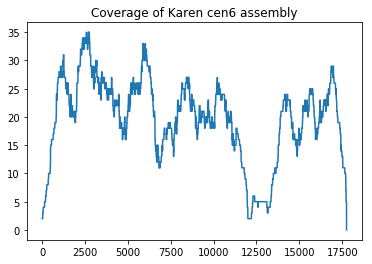

In [334]:
cov = get_cov(ref_monomers, monomer_strings)
plt.plot(cov)
plt.title('Coverage of Karen cen6 assembly')

00739941-c14c-40bd-9fad-fabff753795b {'editDistance': 0, 'alphabetLength': 18, 'locations': [(497, 1294)], 'cigar': None} [[797]]
01f80610-395e-4ef8-93d0-526989b8cb53 {'editDistance': 3, 'alphabetLength': 19, 'locations': [(3848, 5061)], 'cigar': None} [[1213]]
0352811e-b17c-4fc1-a73f-99757d30745c {'editDistance': 1, 'alphabetLength': 18, 'locations': [(5666, 6288)], 'cigar': None} [[622]]
03e1fc3d-8e77-4170-94e1-3711db044f8b {'editDistance': 1, 'alphabetLength': 18, 'locations': [(2649, 3306)], 'cigar': None} [[657]]
04203cad-4a32-4b9c-b7dd-c8603e54b46b {'editDistance': 1, 'alphabetLength': 19, 'locations': [(13836, 14454)], 'cigar': None} [[618]]
04b2f961-f6b4-438d-9a64-83dbd6049ffc {'editDistance': 0, 'alphabetLength': 18, 'locations': [(15519, 16317)], 'cigar': None} [[798]]
050b88c4-e343-431d-99dc-4b8151b4adef {'editDistance': 0, 'alphabetLength': 18, 'locations': [(14079, 14785)], 'cigar': None} [[706]]
0540aa3e-f34b-4e74-a5e5-884b69594a0d {'editDistance': 0, 'alphabetLength': 18

747e0d59-fbd1-4378-bc82-77287e4bc114 {'editDistance': 0, 'alphabetLength': 18, 'locations': [(844, 1642)], 'cigar': None} [[798]]
74ad6ed9-7075-4c36-acce-e2ae44e8fd9f {'editDistance': 0, 'alphabetLength': 18, 'locations': [(5761, 6390)], 'cigar': None} [[629]]
75d67010-b675-4529-bee0-70051c4009e5 {'editDistance': 1, 'alphabetLength': 18, 'locations': [(8006, 8687)], 'cigar': None} [[681]]
76b12196-6464-428c-97e7-f75f1c263d5e {'editDistance': 0, 'alphabetLength': 18, 'locations': [(1418, 2438)], 'cigar': None} [[1020]]
794fcdf4-9216-42c1-abf6-e151c28caa2b {'editDistance': 0, 'alphabetLength': 18, 'locations': [(3454, 4212)], 'cigar': None} [[758]]
7961926d-fd27-4842-9c67-65050f1f6aaf {'editDistance': 18, 'alphabetLength': 18, 'locations': [(6678, 7625)], 'cigar': None} [[947]]
7a11e524-31c6-47b5-98bc-e2bb4551972f {'editDistance': 0, 'alphabetLength': 18, 'locations': [(888, 1618)], 'cigar': None} [[730]]
7aeafbcb-6498-4d7b-92b7-20351a352c58 {'editDistance': 39, 'alphabetLength': 19, 'lo

d374a0fc-8776-4408-81e0-de6c6d65803b {'editDistance': 0, 'alphabetLength': 18, 'locations': [(13526, 14229)], 'cigar': None} [[703]]
d4447330-d508-4941-89a0-b491c5ad046e {'editDistance': 1, 'alphabetLength': 18, 'locations': [(7628, 8515)], 'cigar': None} [[887]]
d52f274e-53e6-44c9-b80a-8d28a6c7c518 {'editDistance': 0, 'alphabetLength': 18, 'locations': [(8711, 9681)], 'cigar': None} [[970]]
d67fce41-f360-4513-a994-e8ef3970b2cd {'editDistance': 0, 'alphabetLength': 18, 'locations': [(12487, 13107)], 'cigar': None} [[620]]
d79e3ebd-82e3-4621-8744-3ffc2832ddc4 {'editDistance': 3, 'alphabetLength': 19, 'locations': [(10254, 11415)], 'cigar': None} [[1161]]
d84233c4-af6b-45a7-b6f9-1ec9627419dc {'editDistance': 12, 'alphabetLength': 18, 'locations': [(10825, 12564)], 'cigar': None} [[1739]]
d84eb6b3-6e9a-4fa0-8934-3594a7518977 {'editDistance': 0, 'alphabetLength': 18, 'locations': [(8682, 10206)], 'cigar': None} [[1524]]
d8a483ac-1d71-4541-b105-24de473380e2 {'editDistance': 0, 'alphabetLeng

Text(0.5, 1.0, 'Coverage of our cen6 assembly')

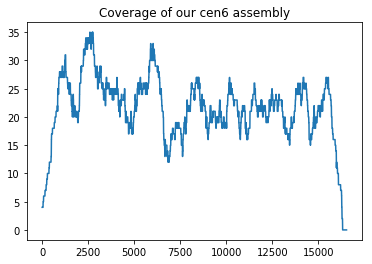

In [335]:
cov = get_cov(scaffold, monomer_strings)
plt.plot(cov)
plt.title('Coverage of our cen6 assembly')